## Load CORDEX Data from CDS  API

In [ ]:
"""
This script makes calls to the CORDEX API

Data: CORDEX regional climate model data on single levels - Experiment: Historical
Temporal coverage: 1 Jan 1971 to 31 Dec 2000
Spatial coverage: Domain: Africa
Format: NetCDF in zip archives

Data: CORDEX regional climate model data on single levels - Experiment: RCP4.5
Temporal coverage: 1 Jan 2071 to 31 Dec 2100
Spatial coverage: Domain: Africa
Format: NetCDF in zip archives

"""

# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import cartopy.crs as ccrs
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
# import cartopy.feature as cfeature

# Other libraries (e.g. paths, filenames, zipfile extraction)
from glob import glob
from pathlib import Path
from os.path import basename
import zipfile
import yaml
import urllib3 
urllib3.disable_warnings() # Disable "InsecureRequestWarning" 
                           # for data download via API

import os
from dotenv import load_dotenv

load_dotenv()

URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = os.getenv('CDS_API_KEY')

def call_api(url=URL, key=KEY):
    client = cdsapi.Client(url=url, key=key)
    return client

def retrieve_cordex_hist_proj(client, data_dir):
    client.retrieve(
        'projections-cordex-domains-single-levels',
        {
            'format': 'zip',
            'domain': 'africa',
            'experiment': 'historical',
            'horizontal_resolution': '0_44_degree_x_0_44_degree',
            'temporal_resolution': 'daily_mean',
            'variable': '2m_air_temperature',
            'gcm_model': 'cccma_canesm2',
            'rcm_model': 'cccma_canrcm4',
            'ensemble_member': 'r1i1p1',
            'start_year': ['1971', '1976', '1981', '1986', '1991', '1996'],
            'end_year': ['1975', '1980', '1985', '1990', '1995', '2000'],
        },
        f'{data_dir}1971-2000_cordex_historical_africa.zip')
    
    # client.retrieve(
    #     'projections-cordex-domains-single-levels',
    #     {
    #         'format': 'zip',
    #         'domain': 'africa',
    #         'experiment': 'rcp_4_5',
    #         'horizontal_resolution': '0_44_degree_x_0_44_degree',
    #         'temporal_resolution': 'daily_mean',
    #         'variable': '2m_air_temperature',
    #         'gcm_model': 'cccma_canesm2',
    #         'rcm_model': 'cccma_canrcm4',
    #         'ensemble_member': 'r1i1p1',
    #         'start_year': ['2071', '2076', '2081', '2086', '2091', '2096'],
    #         'end_year': ['2075', '2080', '2085', '2090', '2095', '2100'],
    #     },
    #     f'{data_dir}2071-2100_cordex_rcp_4_5_africa.zip')

def unzip_files(data_dir):
    cordex_zip_paths = glob(f'{data_dir}*.zip')
    for j in cordex_zip_paths:
        with zipfile.ZipFile(j, 'r') as zip_ref:
            zip_ref.extractall(f'{data_dir}')

def load_hist_proj(data_dir):
    hist_data = xr.open_mfdataset(f'{data_dir}*CanESM2_historical*.nc')
    # proj_data = xr.open_mfdataset(f'{data_dir}*CanESM2_rcp45*.nc')
    return hist_data


In [ ]:
config_path = os.getenv('CONFIG_PATH', 'config.yaml')
# print(config_path)
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
data_dir = config['data_dir']

In [ ]:
def main():
    data_dir = config['data_dir']
    client = call_api()
    retrieve_cordex_hist_proj(client, data_dir)
    unzip_files(data_dir)
    hist_data, proj_data = load_hist_proj(data_dir)

In [ ]:
main()

In [ ]:
hist_data, proj_data = load_hist_proj(data_dir)
hist_data

In [ ]:
def extract_climate_data(lat, lon, _hist, _future):
    """
    Extracts climate data for a given latitude and longitude from historical and future datasets.

    Args:
    - lat (float): Latitude of the location to extract data for.
    - lon (float): Longitude of the location to extract data for.
    - hist (xarray.Dataset): Historical climate dataset.
    - future (xarray.Dataset): Future climate dataset.

    Returns:
    - df (pandas.DataFrame): DataFrame containing present day and future temperature, precipitation, and wind speed data for each month of the year.
    - data_dict (dict): Dictionary containing string representations of the extracted climate data.
    """
    hist_temp = _hist.sel(rlat=lat, rlon=lon, method="nearest")["tas"].values - 273.15
    hist_temp_str = np.array2string(hist_temp.ravel(), precision=3, max_line_width=100)[
        1:-1
    ]

    hist_pr = _hist.sel(rlat=lat, rlon=lon, method="nearest")["pr"].values
    hist_pr = convert_to_mm_per_month(hist_pr)

    hist_pr_str = np.array2string(hist_pr.ravel(), precision=3, max_line_width=100)[
        1:-1
    ]


    future_temp = _future.sel(rlat=lat, rlon=lon, method="nearest")["tas"].values - 273.15
    future_temp_str = np.array2string(
        future_temp.ravel(), precision=3, max_line_width=100
    )[1:-1]

    future_pr = _future.sel(rlat=lat, rlon=lon, method="nearest")["pr"].values
    future_pr = convert_to_mm_per_month(future_pr)
    future_pr_str = np.array2string(future_pr.ravel(), precision=3, max_line_width=100)[
        1:-1
    ]

    df = pd.DataFrame(
        {
            "Present Day Temperature": hist_temp[0, 0, :],
            "Future Temperature": future_temp[0, 0, :],
            "Present Day Precipitation": hist_pr[0, 0, :],
            "Future Precipitation": future_pr[0, 0, :],
            "Month": range(1, 13),
        }
    )
    data_dict = {
        "hist_temp": hist_temp_str,
        "hist_pr": hist_pr_str,
        "future_temp": future_temp_str,
        "future_pr": future_pr_str,
    }
    return df, data_dict

In [ ]:
def convert_to_mm_per_month(monthly_precip_kg_m2_s1):
    days_in_months = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    return monthly_precip_kg_m2_s1 * 60 * 60 * 24

In [ ]:
lat, lon = -1.2833, 36.8172
df, data_dict = extract_climate_data(lat, lon, hist_data, proj_data)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
tas_historical = hist_data['tas']
tas_historical

In [ ]:
tas_climatology = tas_historical.groupby('time.month').mean()

In [ ]:
tas_climatology_degC = tas_climatology - 273.15
tas_climatology_degC

In [ ]:
kiambere_tas_climatology_degC = tas_climatology_degC.sel(rlat=-0.7, rlon=37.783, method="nearest")
kiambere_tas_climatology_degC

In [ ]:
proj_data

In [ ]:
tas_projection = proj_data['tas']
tas_proj_climatology = tas_projection.groupby('time.month').mean()
tas_proj_climatology_degC = tas_proj_climatology - 273.15
tas_proj_climatology_degC

In [ ]:
kiambere_tas_proj_climatology_degC = tas_proj_climatology_degC.sel(rlat=-0.7, rlon=37.783, method="nearest")
kiambere_tas_proj_climatology_degC

In [ ]:
kiambere_tas_difference_climatology = kiambere_tas_proj_climatology_degC - kiambere_tas_climatology_degC
kiambere_tas_difference_climatology

## Load Lat and Lon Data from Geocoding API

In [ ]:
import requests
from requests.structures import CaseInsensitiveDict
import os
import json

from dotenv import load_dotenv

load_dotenv()

GEOCODE_API_KEY = os.getenv('GEOCODE_API')
location_query = "Kiambere"

url = f"https://api.geoapify.com/v1/geocode/search?text={location_query}&apiKey={GEOCODE_API_KEY}"
print(url)

headers = CaseInsensitiveDict()
headers["Accept"] = "application/json"

resp = requests.get(url, headers=headers)

response = resp.json()
lon = response['features'][0]['properties']['lon']
lat = response['features'][0]['properties']['lat']

print(lon, lat)
print(response)

In [ ]:
response = {
    'features'  :  [{'type': 'Feature', 'properties': {'datasource': {'sourcename': 'openstreetmap', 'attribution': '© OpenStreetMap contributors', 'license': 'Open Database License', 'url': 'https://www.openstreetmap.org/copyright'}, 'name': 'Kiambere', 'country': 'Kenya', 'country_code': 'ke', 'state': 'Embu', 'county': 'Mbeere South', 'city': 'Kiambere', 'village': 'Kiambere', 'lon': 37.7833, 'lat': -0.7, 'result_type': 'city', 'formatted': 'Kiambere (Kiambere), Embu, Kenya', 'address_line1': 'Kiambere (Kiambere)', 'address_line2': 'Embu, Kenya', 'category': 'populated_place', 'timezone': {'name': 'Africa/Nairobi', 'offset_STD': '+03:00', 'offset_STD_seconds': 10800, 'offset_DST': '+03:00', 'offset_DST_seconds': 10800, 'abbreviation_STD': 'EAT', 'abbreviation_DST': 'EAT'}, 'plus_code': '6GFV7QXM+X8', 'rank': {'importance': 0.37500999999999995, 'popularity': 0.6095602004872759, 'confidence': 1, 'confidence_city_level': 1, 'match_type': 'full_match'}, 'place_id': '51787aa52c43e4424059666666666666e6bff00103f9018794ae0200000000c002089203084b69616d62657265'}, 'geometry': {'type': 'Point', 'coordinates': [37.7833, -0.7]}, 'bbox': [37.7633, -0.72, 37.8033, -0.68]}]
}

In [ ]:
response['features'][0]['properties']['lon']
response['features'][0]['properties']['lat']


## Conversation Agent

In [ ]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [ ]:
from langchain.tools import tool

from requests.structures import CaseInsensitiveDict
from requests.exceptions import Timeout
import os
from dotenv import load_dotenv
import requests
from pydantic import BaseModel, Field
import datetime

# define the input schema
class LocationInput(BaseModel):
    location: str = Field(description="The location to get longitude and latitude for", required=True)

@tool(args_schema=LocationInput)
def get_lat_lon(location: str):
    """
    Get the latitude and longitude of the location given by user.
    """
    load_dotenv()

    GEOCODE_API_KEY = os.getenv('GEOCODE_API')
    location_query = location

    url = f"https://api.geoapify.com/v1/geocode/search?text={location_query}&apiKey={GEOCODE_API_KEY}"
    print(url)

    headers = CaseInsensitiveDict()
    headers["Accept"] = "application/json"

    resp = requests.get(url, headers=headers)

    response = resp.json()
    lat = response['features'][0]['properties']['lat']
    lon = response['features'][0]['properties']['lon']

    return lat, lon


In [ ]:
from langchain.tools.render import format_tool_to_openai_function
format_tool_to_openai_function(get_lat_lon)

get_lat_lon("Nairobi")

In [ ]:
# @tool
# def get_soil_from_api(lat: float, lon:float):
#     """
#     Retrieves the soil type at a given latitude and longitude using the ISRIC SoilGrids API.

#     Parameters:
#     lat (float): The latitude of the location.
#     lon (float): The longitude of the location.

#     Returns:
#     str: The name of the World Reference Base (WRB) soil class at the given location.
#     """
#     try:
#         url = f"https://rest.isric.org/soilgrids/v2.0/classification/query?lon={lon}&lat={lat}&number_classes=5"
#         response = requests.get(url, timeout=3)  # Set timeout to 2 seconds
#         data = response.json()
#         return data["wrb_class_name"]
#     except Timeout:
#         return "not found"

In [ ]:
@tool
def get_soil_from_api(location: str):
    """
    Retrieves the soil type at a given location using the ISRIC SoilGrids API.

    Parameters:
    location: location name

    Returns:
    str: The name of the World Reference Base (WRB) soil class at the given location.
    """
    lat, lon = get_lat_lon(location)

    try:
        url = f"https://rest.isric.org/soilgrids/v2.0/classification/query?lon={lon}&lat={lat}&number_classes=5"
        response = requests.get(url, timeout=3)  # Set timeout to 2 seconds
        data = response.json()
        return data["wrb_class_name"]
    except Timeout:
        return "not found"

In [ ]:
get_soil_from_api({"location":"Nairobi"})

In [ ]:
tools = [get_lat_lon, get_soil_from_api]

functions = [
    format_tool_to_openai_function(f) for f in tools
]
functions

In [ ]:
from langchain.chat_models import ChatOllama, ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser


In [ ]:
somodel = ChatOllama(
    model = "llama3", 
)
somodel.invoke("hello")

In [ ]:
from langchain.chains import LLMChain

from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

system_role = config['system_role']

content_message = "{user_message} \n"

system_message_prompt = SystemMessagePromptTemplate.from_template(system_role)
human_message_prompt = HumanMessagePromptTemplate.from_template(content_message)
chat_prompt = ChatPromptTemplate.from_messages(
    [system_message_prompt, human_message_prompt]
)



chain = LLMChain(
    llm=somodel,
    prompt=chat_prompt,
    verbose=True,
) 
output = chain.run(
    user_message="Hello"
)



In [ ]:
from ollama_functions import OllamaFunctions

In [ ]:
# Example: reuse your existing OpenAI setup
from openai import OpenAI

# Point to the local server
# client = OpenAI(base_url="http://localhost:1234/v1", api_key="lm-studio")



# functions = [format_tool_to_openai_function(f) for f in tools]


model = OllamaFunctions(
    model="llama3", temperature=0, format="json"
).bind_tools(functions)

# structured_model = model.with_structured_output(LocationInput)

# chain = prompt | model

In [ ]:
# functions = [format_tool_to_openai_function(f) for f in tools]
# model = ChatOpenAI(temperature=0).bind(functions=functions)
# prompt = ChatPromptTemplate.from_messages([
#     ("system", "You are a helpful data assistant"),
#     ("user", "{input}"),
# ])
# chain = prompt | model | OpenAIFunctionsAgentOutputParser

In [ ]:
model.invoke("what is the latitude and longitude for Nairobi?")

In [ ]:
model.invoke("what is the soil type in Nairobi?")

In [ ]:
from langchain.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model

In [ ]:
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [ ]:
from langchain.schema.agent import AgentFinish

def route(result):
    if isinstance(result, AgentFinish):
        return result.return_values['output']
    else:
        tools = {
            "get_lat_lon": get_lat_lon,
            "get_soil_from_api": get_soil_from_api
        }
        return tools[result.tool].run(result.tool_input)

In [ ]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser() | route
result = chain.invoke({"input":"what is the soil type in Nairobi?"})
result

## Seasonal Forecast Anomalies

In [1]:
# Miscellaneous operating system interfaces
import os
import yaml

# CDS API
import cdsapi

# To map GRIB files to NetCDF Common Data Model
import cfgrib

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

# Libraries for plotting and geospatial data visualisation
import matplotlib.path as mpath
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# To work with data labels in dictionary format
from collections import OrderedDict

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

# Interactive HTML widgets
import ipywidgets as widgets

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

In [2]:


URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = KEY = os.getenv('CDS_API_KEY')

config_path = os.getenv('CONFIG_PATH', 'config.yaml')
# print(config_path)
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)
data_dir = config['data_dir']

DATADIR = f'{data_dir}/seasonal'

The next step is then to request the seasonal forecast monthly statistics data on single levels with the help of the CDS API. Below, we download two separate files of total precipitation for six monthly lead times (start date in May):

Retrospective forecasts (Hindcasts) for 1993 to 2016

Forecasts for 2021

Seasonal forecast data are disseminated in the GRIB data format.

In [3]:
# c = cdsapi.Client(url=URL, key=KEY)

# c.retrieve(
#     'seasonal-monthly-single-levels',
#     {
#         'format': 'grib',
#         'originating_centre': 'ecmwf',
#         'system': '51',
#         'variable': 'total_precipitation',
#         'product_type': 'monthly_mean',
#         'year': [
#             '2002', '2003', '2004',
#             '2005', '2006', '2007',
#             '2008', '2009', '2010',
#             '2011', '2012', '2013',
#             '2014', '2015', '2016',
#             '2017', '2018', '2019',
#             '2020', '2021', '2022',
#         ],
#         'month': '03',
#         'leadtime_month': [
#             '1', '2', '3',
#             '4', '5', '6',
#         ],
#     },
#     f'{DATADIR}/ecmwf_seas5_2002-2022_05_hindcast_monthly_tp.grib')

In [4]:
# # Forecast data request
# c.retrieve(
#     'seasonal-monthly-single-levels',
#     {
#         'format': 'grib',
#         'originating_centre': 'ecmwf',
#         'system': '51',
#         'variable': 'total_precipitation',
#         'product_type': 'monthly_mean',
#         'year': '2024',
#         'month': '03',
#         'leadtime_month': [
#             '1', '2', '3',
#             '4', '5', '6',
#         ],
#     },
#     f'{DATADIR}/ecmwf_seas5_2024_03_forecast_monthly_tp.grib')

## Calculate seasonal hindcast climate mean
Seasonal forecasts are affected by systematic errors (biases) which are dependent on the leadtime, the time of year, the variable and the location. Hindcast data can help us to understand and account for these biases. We will calculate the hindcast climate mean for each lead time month, averaged over the years 2002 to 2022. In the next section we will then calculate the anomalies, i.e. the deviation of the 2024 forecast for each lead time month with respect to the hindcast mean. Anomalies are thus calculated “in the model space” where the model climate calculated from the hindcasts is taken as the reference.

In [5]:
ds = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2002-2022_05_hindcast_monthly_tp.grib')
ds 

<xarray.Dataset> Size: 2GB
Dimensions:     (number: 51, time: 21, step: 6, latitude: 180, longitude: 360)
Coordinates:
  * number      (number) int32 204B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49 50
  * time        (time) datetime64[ns] 168B 2002-03-01 2003-03-01 ... 2022-03-01
  * step        (step) timedelta64[ns] 48B 31 days 61 days ... 153 days 184 days
    surface     float64 8B ...
  * latitude    (latitude) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    valid_time  (time, step) datetime64[ns] 1kB ...
Data variables:
    tprate      (number, time, step, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-20T13:24 GRIB to CDM+CF via cfgrib-0.9.1...

Replace the dimension “step” with “forecastMonth”, which is part of the GRIB metadata and provides the same integer indices used in the CDS API syntax for “leadtime_month”, with the value 1 corresponding to the first complete calendar month after the forecast start date. 

For instance for a forecast with start date on the 1st March, forecastMonth=1 is March, and for a forecast with start date on 17th April, forecastMonth=1 would also be March. 
This is more coherent and avoids the ambiguity described above.

In [6]:
ds_hindcast = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2002-2022_05_hindcast_monthly_tp.grib', engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
ds_hindcast

<xarray.Dataset> Size: 2GB
Dimensions:        (number: 51, forecastMonth: 6, time: 21, latitude: 180,
                    longitude: 360)
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
  * time           (time) datetime64[ns] 168B 2002-03-01 ... 2022-03-01
    surface        float64 8B ...
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    tprate         (number, forecastMonth, time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-20T13:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [7]:
# extract the total precipitation data array from the dataset
tprate_hindcast = ds_hindcast['tprate']
tprate_hindcast

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, time: 21,
                            latitude: 180, longitude: 360)> Size: 2GB
[416404800 values with dtype=float32]
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
  * time           (time) datetime64[ns] 168B 2002-03-01 ... 2022-03-01
    surface        float64 8B ...
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Attributes: (12/30)
    GRIB_paramId:                             172228
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      64800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           tprate
    GRIB_totalNumber:                         0
    GRIB_units:                               m s**-1
    long_name:                                Mean total precipitation rate
    units:                                    m s**-1
    standard_name:                            unknown

In [8]:
# Average over ensemble members and years to create hindcast climatology
tprate_hindcast_mean = tprate_hindcast.mean(['number', 'time'])
tprate_hindcast_mean

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 180, longitude: 360)> Size: 2MB
array([[[4.77383999e-09, 4.77610529e-09, 4.77857309e-09, ...,
         4.76853534e-09, 4.77013273e-09, 4.77138284e-09],
        [4.98555330e-09, 4.99700148e-09, 5.00831066e-09, ...,
         4.95366104e-09, 4.96423835e-09, 4.97487473e-09],
        [5.32347944e-09, 5.33398214e-09, 5.34424949e-09, ...,
         5.28262323e-09, 5.29700950e-09, 5.31124611e-09],
        ...,
        [1.92346516e-09, 1.90994953e-09, 1.89615079e-09, ...,
         1.95692818e-09, 1.94600891e-09, 1.93531391e-09],
        [2.07514361e-09, 2.07528261e-09, 2.07572071e-09, ...,
         2.08903317e-09, 2.08347739e-09, 2.07767048e-09],
        [2.41003550e-09, 2.40657383e-09, 2.40310660e-09, ...,
         2.41998777e-09, 2.41680387e-09, 2.41342768e-09]],

       [[5.01746733e-09, 5.02095032e-09, 5.02447062e-09, ...,
         5.00771780e-09, 5.01116881e-09, 5.01389330e-09],
        [5.14898479e-09, 5.16041165e-09, 5.17127718e-09, ...,
         5.11419707e-09, 5.12575182e-09, 5.13739229e-09],
        [5.29439159e-09, 5.30969135e-09, 5.32541344e-09, ...,
         5.25064525e-09, 5.26564570e-09, 5.27970068e-09],
...
        [1.32307043e-09, 1.31194811e-09, 1.30113564e-09, ...,
         1.35384093e-09, 1.34374434e-09, 1.33348754e-09],
        [1.47810919e-09, 1.47661339e-09, 1.47488255e-09, ...,
         1.49140034e-09, 1.48682755e-09, 1.48135715e-09],
        [1.73100478e-09, 1.72797043e-09, 1.72545966e-09, ...,
         1.73871884e-09, 1.73643244e-09, 1.73296000e-09]],

       [[1.36266829e-08, 1.36283385e-08, 1.36300162e-08, ...,
         1.36212446e-08, 1.36240548e-08, 1.36254963e-08],
        [1.32888474e-08, 1.32955247e-08, 1.33017215e-08, ...,
         1.32326807e-08, 1.32539100e-08, 1.32748834e-08],
        [1.28062521e-08, 1.28161775e-08, 1.28258675e-08, ...,
         1.28034632e-08, 1.28035058e-08, 1.28031639e-08],
        ...,
        [1.33514355e-09, 1.32258959e-09, 1.31053779e-09, ...,
         1.36736722e-09, 1.35651201e-09, 1.34635136e-09],
        [1.49237267e-09, 1.48864387e-09, 1.48666723e-09, ...,
         1.50731982e-09, 1.50162516e-09, 1.49716983e-09],
        [1.74778969e-09, 1.74478743e-09, 1.74106940e-09, ...,
         1.75654014e-09, 1.75311043e-09, 1.75140102e-09]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    surface        float64 8B ...
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5

## Load monthly seasonal forecast data for 2024 and calculate seasonal forecast anomalies

In [9]:
seas5_forecast = xr.open_dataset(f'{DATADIR}/ecmwf_seas5_2024_03_forecast_monthly_tp.grib', engine='cfgrib', 
                                 backend_kwargs=dict(time_dims=('forecastMonth', 'time')))
seas5_forecast

<xarray.Dataset> Size: 79MB
Dimensions:        (number: 51, forecastMonth: 6, latitude: 180, longitude: 360)
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B ...
    surface        float64 8B ...
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
Data variables:
    tprate         (number, forecastMonth, latitude, longitude) float32 79MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-05-20T13:24 GRIB to CDM+CF via cfgrib-0.9.1...

In [10]:
# calculate 2024 anomalies
seas5_anomalies_202403 = seas5_forecast['tprate'] - tprate_hindcast_mean
seas5_anomalies_202403

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 180,
                            longitude: 360)> Size: 79MB
array([[[[-1.24500055e-09, -1.24726585e-09, -1.24973365e-09, ...,
          -1.24697186e-09, -1.24856925e-09, -1.24981936e-09],
         [-1.11474385e-09, -1.11891607e-09, -1.11567333e-09, ...,
          -1.11195542e-09, -1.11525678e-09, -1.11134124e-09],
         [-1.49632573e-09, -1.51410440e-09, -1.53892366e-09, ...,
          -1.44091761e-09, -1.46257984e-09, -1.47681645e-09],
         ...,
         [-4.90101515e-10, -4.76585882e-10, -4.62787142e-10, ...,
          -5.16288567e-10, -5.05369302e-10, -4.94674302e-10],
         [-2.41602294e-10, -2.41741294e-10, -2.34903430e-10, ...,
          -2.55491850e-10, -2.49936072e-10, -2.44129161e-10],
         [-1.39936729e-10, -1.36475053e-10, -1.33007827e-10, ...,
          -1.49888990e-10, -1.46705093e-10, -1.43328904e-10]],

        [[-2.24532748e-09, -2.24881047e-09, -2.25233077e-09, ...,
          -2.24285390e-09, -2.24630492e-09, -2.23447749e-09],
         [-1.91118366e-09, -1.90805860e-09, -1.90437222e-09, ...,
          -1.89822380e-09, -1.90250260e-09, -1.89959115e-09],
         [-1.51816959e-09, -1.49708956e-09, -1.47643187e-09, ...,
          -1.55445878e-09, -1.54035540e-09, -1.53258251e-09],
...
          -6.04417294e-10, -5.94320704e-10, -6.05891781e-10],
         [-6.55925980e-10, -6.54430177e-10, -6.74527212e-10, ...,
          -6.91044999e-10, -6.86472212e-10, -6.81001810e-10],
         [-7.05094760e-10, -7.02060410e-10, -6.99549640e-10, ...,
          -6.90980939e-10, -7.10522419e-10, -7.07049974e-10]],

        [[ 1.08496385e-08,  1.07533955e-08,  1.06644062e-08, ...,
           1.10806315e-08,  1.10123377e-08,  1.09163087e-08],
         [ 7.76777398e-09,  7.69561304e-09,  7.57300089e-09, ...,
           8.18773849e-09,  8.05009392e-09,  7.89815324e-09],
         [ 5.55826496e-09,  5.57016744e-09,  5.58958124e-09, ...,
           5.58288171e-09,  5.58283908e-09,  5.56135316e-09],
         ...,
         [ 4.91121810e-10,  4.74571937e-10,  5.15727572e-10, ...,
           5.46209633e-10,  5.13409093e-10,  4.79913997e-10],
         [ 1.03966058e-09,  9.92457672e-10,  1.02353814e-09, ...,
           1.06836917e-09,  1.05223597e-09,  1.03486342e-09],
         [ 1.46818357e-09,  1.47118584e-09,  1.44580004e-09, ...,
           1.48126100e-09,  1.46286283e-09,  1.48640011e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B ...
    surface        float64 8B 0.0
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5

A closer look at the coordinate information of forecastMonth reveals that it only gives integer values from 1 to 6, but not the actual time for which the forecast is valid. We will need this latter information when we convert from precipitation rate to accumulation, as for this we will need to know the number of days per month. Additionally, this information will be useful for later labelling.


To calculate the time for which the forecast is valid, let us assign a new coordinate with the name valid_time based on the dimension forecastMonth. This coordinate information shall provide us the valid timestamp for each of the forecast months. We can use the value of the time dimension as the start date. The function relativedelta() allows us to add a specific number of months to the start date.


In a second step, with the xarray function assign_coords(), we assign this newly created DateTimeIndex object as a new coordinate.


In [11]:
# Convert forecast lead time month into dates
valid_time = [pd.to_datetime(seas5_anomalies_202403.time.values) + relativedelta(months=fcmonth-1) for fcmonth in seas5_anomalies_202403.forecastMonth]
seas5_anomalies_202403 = seas5_anomalies_202403.assign_coords(valid_time=('forecastMonth',valid_time))
seas5_anomalies_202403

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 180,
                            longitude: 360)> Size: 79MB
array([[[[-1.24500055e-09, -1.24726585e-09, -1.24973365e-09, ...,
          -1.24697186e-09, -1.24856925e-09, -1.24981936e-09],
         [-1.11474385e-09, -1.11891607e-09, -1.11567333e-09, ...,
          -1.11195542e-09, -1.11525678e-09, -1.11134124e-09],
         [-1.49632573e-09, -1.51410440e-09, -1.53892366e-09, ...,
          -1.44091761e-09, -1.46257984e-09, -1.47681645e-09],
         ...,
         [-4.90101515e-10, -4.76585882e-10, -4.62787142e-10, ...,
          -5.16288567e-10, -5.05369302e-10, -4.94674302e-10],
         [-2.41602294e-10, -2.41741294e-10, -2.34903430e-10, ...,
          -2.55491850e-10, -2.49936072e-10, -2.44129161e-10],
         [-1.39936729e-10, -1.36475053e-10, -1.33007827e-10, ...,
          -1.49888990e-10, -1.46705093e-10, -1.43328904e-10]],

        [[-2.24532748e-09, -2.24881047e-09, -2.25233077e-09, ...,
          -2.24285390e-09, -2.24630492e-09, -2.23447749e-09],
         [-1.91118366e-09, -1.90805860e-09, -1.90437222e-09, ...,
          -1.89822380e-09, -1.90250260e-09, -1.89959115e-09],
         [-1.51816959e-09, -1.49708956e-09, -1.47643187e-09, ...,
          -1.55445878e-09, -1.54035540e-09, -1.53258251e-09],
...
          -6.04417294e-10, -5.94320704e-10, -6.05891781e-10],
         [-6.55925980e-10, -6.54430177e-10, -6.74527212e-10, ...,
          -6.91044999e-10, -6.86472212e-10, -6.81001810e-10],
         [-7.05094760e-10, -7.02060410e-10, -6.99549640e-10, ...,
          -6.90980939e-10, -7.10522419e-10, -7.07049974e-10]],

        [[ 1.08496385e-08,  1.07533955e-08,  1.06644062e-08, ...,
           1.10806315e-08,  1.10123377e-08,  1.09163087e-08],
         [ 7.76777398e-09,  7.69561304e-09,  7.57300089e-09, ...,
           8.18773849e-09,  8.05009392e-09,  7.89815324e-09],
         [ 5.55826496e-09,  5.57016744e-09,  5.58958124e-09, ...,
           5.58288171e-09,  5.58283908e-09,  5.56135316e-09],
         ...,
         [ 4.91121810e-10,  4.74571937e-10,  5.15727572e-10, ...,
           5.46209633e-10,  5.13409093e-10,  4.79913997e-10],
         [ 1.03966058e-09,  9.92457672e-10,  1.02353814e-09, ...,
           1.06836917e-09,  1.05223597e-09,  1.03486342e-09],
         [ 1.46818357e-09,  1.47118584e-09,  1.44580004e-09, ...,
           1.48126100e-09,  1.46286283e-09,  1.48640011e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-03-01 ... 2024-08-01

convert the precipitation from rates in m/s to total accumulated precipitation per month in mm. The conversion has to be done per month, as it is dependent on the number of days of a specific month. For this, we create a new dimension called numdays. 

The function monthrange() from the calendar library returns the number of days in a month, based on a given year and month. With the help of the new coordinate information valid_time, we can thus create a list of the number of days. Again, with the function assign_coords(), we assign this list as a new coordinate in our data array.

In [12]:
# Convert from precipitation rates to accumulation
numdays = [monthrange(dd.year,dd.month)[1] for dd in valid_time]
seas5_anomalies_202403 = seas5_anomalies_202403.assign_coords(numdays=('forecastMonth',numdays))
seas5_anomalies_202403

<xarray.DataArray 'tprate' (number: 51, forecastMonth: 6, latitude: 180,
                            longitude: 360)> Size: 79MB
array([[[[-1.24500055e-09, -1.24726585e-09, -1.24973365e-09, ...,
          -1.24697186e-09, -1.24856925e-09, -1.24981936e-09],
         [-1.11474385e-09, -1.11891607e-09, -1.11567333e-09, ...,
          -1.11195542e-09, -1.11525678e-09, -1.11134124e-09],
         [-1.49632573e-09, -1.51410440e-09, -1.53892366e-09, ...,
          -1.44091761e-09, -1.46257984e-09, -1.47681645e-09],
         ...,
         [-4.90101515e-10, -4.76585882e-10, -4.62787142e-10, ...,
          -5.16288567e-10, -5.05369302e-10, -4.94674302e-10],
         [-2.41602294e-10, -2.41741294e-10, -2.34903430e-10, ...,
          -2.55491850e-10, -2.49936072e-10, -2.44129161e-10],
         [-1.39936729e-10, -1.36475053e-10, -1.33007827e-10, ...,
          -1.49888990e-10, -1.46705093e-10, -1.43328904e-10]],

        [[-2.24532748e-09, -2.24881047e-09, -2.25233077e-09, ...,
          -2.24285390e-09, -2.24630492e-09, -2.23447749e-09],
         [-1.91118366e-09, -1.90805860e-09, -1.90437222e-09, ...,
          -1.89822380e-09, -1.90250260e-09, -1.89959115e-09],
         [-1.51816959e-09, -1.49708956e-09, -1.47643187e-09, ...,
          -1.55445878e-09, -1.54035540e-09, -1.53258251e-09],
...
          -6.04417294e-10, -5.94320704e-10, -6.05891781e-10],
         [-6.55925980e-10, -6.54430177e-10, -6.74527212e-10, ...,
          -6.91044999e-10, -6.86472212e-10, -6.81001810e-10],
         [-7.05094760e-10, -7.02060410e-10, -6.99549640e-10, ...,
          -6.90980939e-10, -7.10522419e-10, -7.07049974e-10]],

        [[ 1.08496385e-08,  1.07533955e-08,  1.06644062e-08, ...,
           1.10806315e-08,  1.10123377e-08,  1.09163087e-08],
         [ 7.76777398e-09,  7.69561304e-09,  7.57300089e-09, ...,
           8.18773849e-09,  8.05009392e-09,  7.89815324e-09],
         [ 5.55826496e-09,  5.57016744e-09,  5.58958124e-09, ...,
           5.58288171e-09,  5.58283908e-09,  5.56135316e-09],
         ...,
         [ 4.91121810e-10,  4.74571937e-10,  5.15727572e-10, ...,
           5.46209633e-10,  5.13409093e-10,  4.79913997e-10],
         [ 1.03966058e-09,  9.92457672e-10,  1.02353814e-09, ...,
           1.06836917e-09,  1.05223597e-09,  1.03486342e-09],
         [ 1.46818357e-09,  1.47118584e-09,  1.44580004e-09, ...,
           1.48126100e-09,  1.46286283e-09,  1.48640011e-09]]]],
      dtype=float32)
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-03-01 ... 2024-08-01
    numdays        (forecastMonth) int32 24B 31 30 31 30 31 31

convert for each month the precipitation accumulations to total precipitation. For this, we multiply the precipitation values with the number of days and then with 24 x 60 x 60 (number of seconds in a day) to retrieve precipitation values in m. As a last step, we convert the values in m to mm by multiplying them by 1000.

In [13]:
seas5_anomalies_202403_tp = seas5_anomalies_202403 * seas5_anomalies_202403.numdays * 24 * 60 * 60 * 1000


As a last step before visualizing the data, we want to add the attributes units and long_name and update them, as they have changed with the previous workflow steps. You can simply specify the name of an attribute (e.g. units ) and assign it a new value.

In [14]:
seas5_anomalies_202403_tp.attrs['units'] = 'mm'
seas5_anomalies_202403_tp.attrs['long_name'] = 'Total precipitation anomaly' 

## Visualize seasonal forecast anomalies for a geographical subregion

To visualise the seasonal forecast anomalies, we could simply look at the ensemble mean to summarise the information given by all individual ensemble members. However, this would mean we lose the richness of information the whole ensemble provides. To highlight the relevance of considering not only the ensemble mean but the complete distribution, we will plot the anomalies for all individual members. 

In [15]:
# Define a geographical subset
def ds_latlon_subset(ds,area,latname='latitude',lonname='longitude'):
    """
     generates a geographical subset of an xarray data array. 
     The latitude and longitude values that are outside the defined area are dropped.
    """

    lon1 = area[1] % 360
    lon2 = area[3] % 360
    if lon2 >= lon1:
        masklon = ( (ds[lonname]<=lon2) & (ds[lonname]>=lon1) ) 
    else:
        masklon = ( (ds[lonname]<=lon2) | (ds[lonname]>=lon1) ) 
        
    mask = ((ds[latname]<=area[0]) & (ds[latname]>=area[2])) * masklon
    dsout = ds.where(mask,drop=True)
    
    if lon2 < lon1:
        dsout[lonname] = (dsout[lonname] + 180) % 360 - 180
        dsout = dsout.sortby(dsout[lonname])        
    
    return dsout

In [16]:
# define Africa
sub = (40, -23, -35, 55) #North, West, South, East
seas5_Africa = ds_latlon_subset(seas5_anomalies_202403_tp, sub)
seas5_Africa

<xarray.DataArray (number: 51, forecastMonth: 6, latitude: 75, longitude: 78)> Size: 14MB
array([[[[ 4.83091765e+01,  3.57089342e+01,  5.00812074e+01, ...,
          -1.42303625e+01, -8.64070610e+00,  3.83311686e-02],
         [ 1.27049233e+01,  2.61220741e+01,  4.30285388e+01, ...,
          -8.17079066e+00, -8.77872495e-01,  2.04425763e+00],
         [ 1.08382028e+01,  3.31797384e+01,  3.40911605e+01, ...,
           1.49167029e+01,  9.92703760e+00,  4.48292212e+00],
         ...,
         [-3.95903950e+01, -5.44807016e+01, -3.45575147e+01, ...,
           1.39494148e+01,  4.94879105e+00,  2.69605735e+01],
         [-1.34059890e+01, -4.39023267e+01, -5.31141489e+01, ...,
          -2.35926261e+01, -7.59671284e+00,  3.41409127e+01],
         [-1.00640859e+01, -3.10789582e+00, -9.14551757e+00, ...,
           1.30191328e+01,  2.82336260e+01,  5.37731700e+01]],

        [[-4.45204664e+01, -4.32105336e+01, -3.77407341e+01, ...,
          -2.11701658e+00, -8.07029016e+00, -1.36798745e+01],
         [-4.73944166e+01, -4.41993015e+01, -3.77896411e+01, ...,
          -8.48698085e+00, -1.52738729e+01, -2.12561422e+01],
         [-4.19541491e+01, -3.92749523e+01, -3.59983823e+01, ...,
          -7.83766626e+00, -8.34811465e+00, -1.11198444e+01],
...
         [-3.12697076e+01, -3.06213059e+01, -3.34934150e+01, ...,
          -1.68607756e+01, -1.45360460e+01, -1.20522348e+01],
         [-4.91764462e+01, -4.04525549e+01, -3.03941213e+01, ...,
          -8.37084877e+00, -9.85974336e+00, -5.17485764e+00],
         [-4.25996046e+01, -4.47765238e+01, -3.43662514e+01, ...,
          -4.65821353e+00, -9.04351522e+00, -1.18950468e+01]],

        [[-8.54647085e+00, -9.48675608e+00, -7.23322450e+00, ...,
          -5.64013720e+00, -6.45843021e+00, -7.52860621e+00],
         [-1.71685478e+00, -4.78990927e+00, -6.94485460e+00, ...,
          -7.05442838e+00, -7.61353997e+00, -8.07209260e+00],
         [-5.19191433e+00, -7.63743480e+00, -8.11476050e+00, ...,
          -9.59080666e+00, -5.58044294e+00, -8.27813363e+00],
         ...,
         [-1.79071382e+01, -1.96626882e+01, -2.59589722e+01, ...,
          -2.51573076e+01, -1.31590119e+01, -1.53160198e+01],
         [-3.64123503e+00, -2.92648112e+00, -1.65263883e+00, ...,
          -1.83148146e+01, -1.84513443e+01, -1.90903826e+01],
         [ 4.59881532e+01,  4.26441566e+01,  3.82711062e+01, ...,
          -1.22829736e+01, -1.90040477e+01, -2.24175224e+01]]]])
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
  * latitude       (latitude) float64 600B 39.5 38.5 37.5 ... -32.5 -33.5 -34.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-03-01 ... 2024-08-01
    numdays        (forecastMonth) int32 24B 31 30 31 30 31 31
  * longitude      (longitude) float64 624B -22.5 -21.5 -20.5 ... 52.5 53.5 54.5
Attributes:
    units:      mm
    long_name:  Total precipitation anomaly

In [17]:
# # define Nairobi
# sub = (-1, 36, -2, 37) #North, West, South, East
# seas5_Nairobi = ds_latlon_subset(seas5_anomalies_202403_tp, sub)
# # seas5_Nairobi

### Spatial Map Visualization

In [18]:
# Select a leadtime to visualise
lead_time = 2

) missing from current font.\Temp\ipykernel_2004\1790750914.py:34: UserWarning: Glyph 13 (
  fig.savefig('{}/TotalPrecAnomalyForecastAfrica.png'.format(DATADIR) )
) missing from current font.s\llms\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.s\llms\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


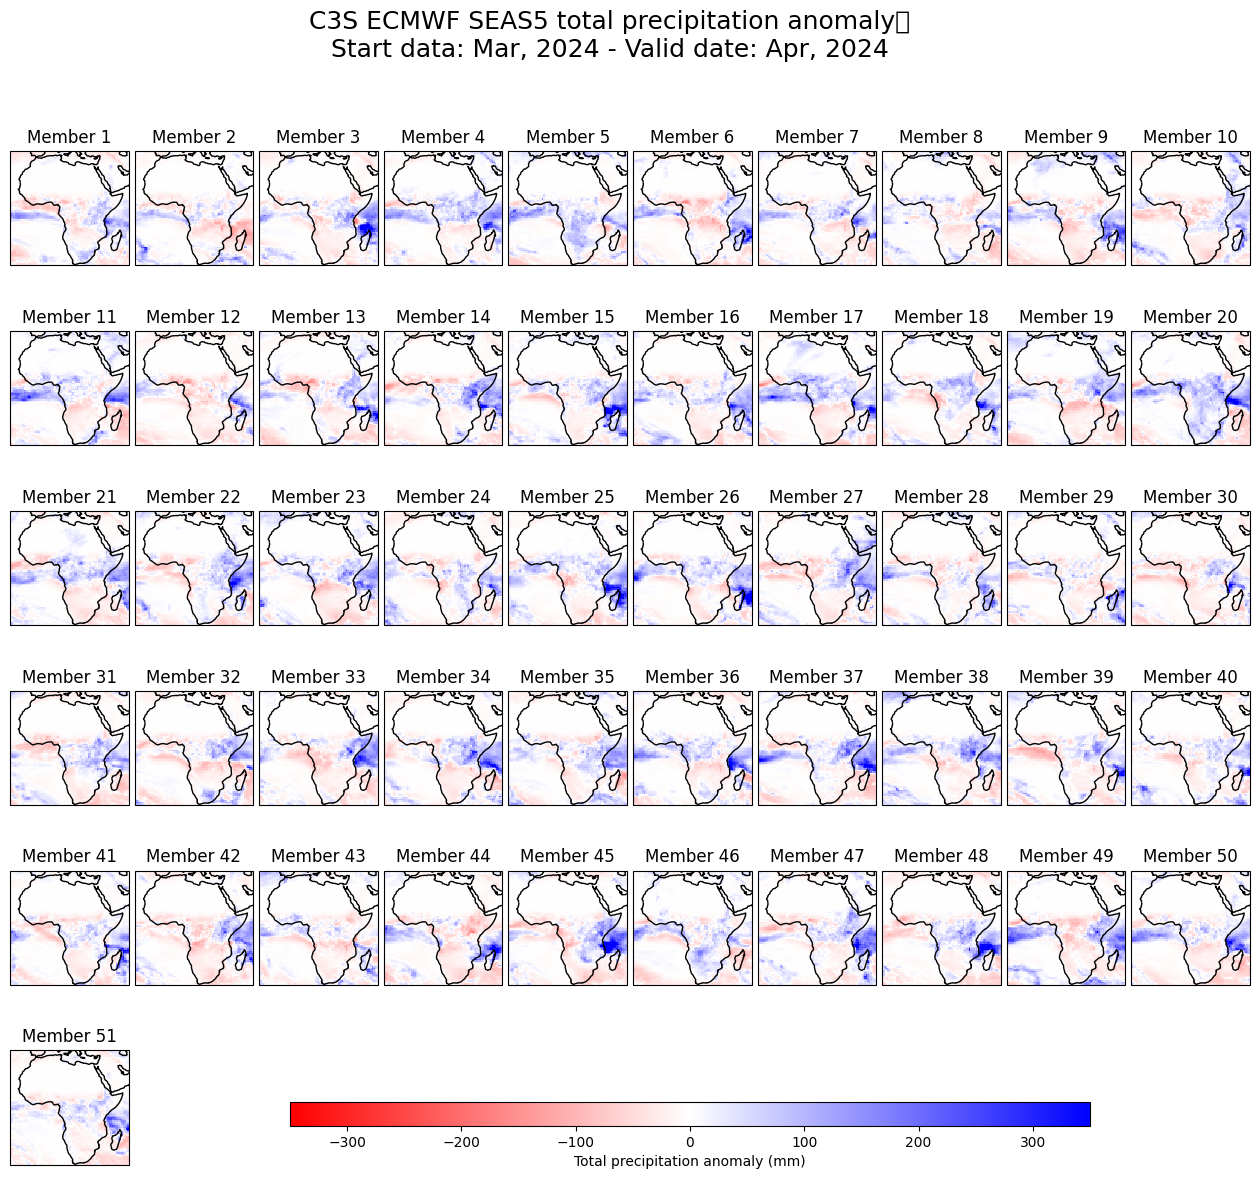

In [19]:
# Define figure and spacing between subplots
fig = plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.15, wspace = 0.05)

new_date_format = seas5_Africa['valid_time'].dt.strftime('%b, %Y')
# seas5_Africa['month_year'] = seas5_Africa['valid_time'].dt.strftime('%b, %Y')

# Define overall title
plt.suptitle('C3S ECMWF SEAS5 total precipitation anomaly'
             + os.linesep + 
             f'Start data: {str(new_date_format[0].data)}' 
             + f' - Valid date: {str(new_date_format[lead_time-1].data)}'
             , fontsize=18)

# Define each subplot looping through the ensemble members
for n in np.arange(51):
    # Add a new subplot iteratively
    ax = plt.subplot(6, 10, n + 1, projection=ccrs.PlateCarree())
    # Plot data
    im = ax.pcolormesh(seas5_Africa.longitude.values, seas5_Africa.latitude.values, 
                       seas5_Africa[n,lead_time-1,:,:], cmap='bwr_r', vmin=-350, vmax=350)
    ax.set_title(f'Member {n+1}') # Set subplot title
    ax.coastlines(color='black') # Add coastlines
    # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
    ax.set_extent([sub[1],sub[3],sub[2],sub[0]], crs=ccrs.PlateCarree())

# Create a colour bar at the bottom of the fugure
fig.subplots_adjust(bottom=0.0)
# Add axis to make space for colour bar (left, bottom, width, height)
cbar_ax = fig.add_axes([0.3, 0.05, 0.5, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Total precipitation anomaly (mm)')

# Save the figure
fig.savefig('{}/TotalPrecAnomalyForecastAfrica.png'.format(DATADIR) )

In [20]:
# # Define figure and spacing between subplots
# fig = plt.figure(figsize=(16, 12))
# plt.subplots_adjust(hspace=0.15, wspace = 0.05)

# new_date_format = seas5_Nairobi['valid_time'].dt.strftime('%b, %Y')

# # Define overall title
# plt.suptitle('C3S ECMWF SEAS5 total precipitation anomaly'
#              + os.linesep + 
#              f'Start data: {str(new_date_format[0].data)}' 
#              + f' - Valid date: {str(new_date_format[lead_time-1].data)}'
#              , fontsize=18)

# # Define each subplot looping through the ensemble members
# for n in np.arange(51):
#     # Add a new subplot iteratively
#     ax = plt.subplot(6, 10, n + 1, projection=ccrs.PlateCarree())
#     # Plot data
#     im = ax.pcolormesh(seas5_Nairobi.longitude.values, seas5_Nairobi.latitude.values, 
#                        seas5_Nairobi[n,lead_time-1,:,:], cmap='bwr_r', vmin=-350, vmax=350)
#     ax.set_title(f'Member {n+1}') # Set subplot title
#     ax.coastlines(color='black') # Add coastlines
#     # Set the extent (x0, x1, y0, y1) of the map in the given coordinate system.
#     ax.set_extent([sub[1],sub[3],sub[2],sub[0]], crs=ccrs.PlateCarree())

# # Create a colour bar at the bottom of the fugure
# fig.subplots_adjust(bottom=0.0)
# # Add axis to make space for colour bar (left, bottom, width, height)
# cbar_ax = fig.add_axes([0.3, 0.05, 0.5, 0.02])
# fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Total precipitation anomaly (mm)')

# # Save the figure
# fig.savefig('{}/TotalPrecAnomalyForecastNairobi.png'.format(DATADIR) )

### Plot of total precipitation anomalies for each seasonal forecast month
Summarise the total precipitation behaviour over the whole region for each lead time month. We will do this by averaging in the spatial (latitude and longitude) dimensions.

To put the anomalies in context they will be compared to the reference climate computed in this subregion from the hindcast data.

In [21]:
# Weighted Average over region
weights =np.cos(np.deg2rad(seas5_Africa.latitude))

anoms_Africa = seas5_Africa.weighted(weights).mean(['latitude','longitude'])
anoms_Africa

<xarray.DataArray (number: 51, forecastMonth: 6)> Size: 2kB
array([[  1.90899215,   3.21230002,   7.15453249,  13.40589469,
         -0.17635319,  -0.80642174],
       [  5.81984446,  -2.18055074,   6.13175373,   1.60414373,
          5.71840569,  -0.86350431],
       [  8.69233473,   9.14753078,  -4.54746114,   3.56900444,
          0.26963697,   4.5060287 ],
       [  3.84289392,  14.05094248,  -1.32604082,   5.28478958,
          0.27992098,   3.0058263 ],
       [  7.25382888,  11.72893923,  -1.52934544,  -2.69263818,
          4.61547209,  -0.39930649],
       [  6.76312438,   3.08199755,   3.3833329 ,   1.72214725,
          4.61068423,   6.29238231],
       [  8.65607782,   3.42144771,  15.28386008,   1.4620747 ,
         -0.92373438,   2.80992376],
       [  3.0498824 ,   0.99021358,   3.91827181,  -8.49347833,
          5.54722357,   0.71774144],
       [  8.64828441,   6.865857  ,   1.63820821,  15.93569955,
         -0.96878011,   8.2405573 ],
       [ -2.14660567,   2.62623439,   9.77130871,   4.39744513,
          6.71259172,   1.55883599],
...
       [  3.90941437,   0.33349123,   1.03034824,  -1.32212081,
          2.83003133,  -0.69718672],
       [  2.62206101,   1.64771184,   3.1878913 ,  -5.23531146,
         -7.02261745,  -4.30975104],
       [  8.81686312,   1.23328432,   8.78834355,  -0.07583415,
          3.99659847,   4.44745945],
       [  8.62254679,   9.54281771,   4.12978644,   9.1909179 ,
         -2.89853338,   5.69091951],
       [  6.69140827,   5.19129823,  -0.91086847,  -1.02913505,
         -3.08551668,  -0.05609603],
       [  4.23052117,  11.12161676,   4.93699944,   1.56342217,
          1.93463482,   3.45738719],
       [  0.86900357,   6.11982764,   4.25709617,   1.53550063,
          0.54365763,  -1.53838192],
       [  2.34241782,  12.21205139,  10.58759107,   2.24057897,
          0.31836487,   9.77335443],
       [ -1.76004519,   6.05156756,   3.40766213,   7.42649976,
          0.26440363,   9.60717593],
       [  3.56222905,   2.88119692,  -0.8817822 ,  -3.97456405,
         -0.25563594,   2.50082066]])
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-03-01 ... 2024-08-01
    numdays        (forecastMonth) int32 24B 31 30 31 30 31 31

In [22]:
# 
seas5_Africa

<xarray.DataArray (number: 51, forecastMonth: 6, latitude: 75, longitude: 78)> Size: 14MB
array([[[[ 4.83091765e+01,  3.57089342e+01,  5.00812074e+01, ...,
          -1.42303625e+01, -8.64070610e+00,  3.83311686e-02],
         [ 1.27049233e+01,  2.61220741e+01,  4.30285388e+01, ...,
          -8.17079066e+00, -8.77872495e-01,  2.04425763e+00],
         [ 1.08382028e+01,  3.31797384e+01,  3.40911605e+01, ...,
           1.49167029e+01,  9.92703760e+00,  4.48292212e+00],
         ...,
         [-3.95903950e+01, -5.44807016e+01, -3.45575147e+01, ...,
           1.39494148e+01,  4.94879105e+00,  2.69605735e+01],
         [-1.34059890e+01, -4.39023267e+01, -5.31141489e+01, ...,
          -2.35926261e+01, -7.59671284e+00,  3.41409127e+01],
         [-1.00640859e+01, -3.10789582e+00, -9.14551757e+00, ...,
           1.30191328e+01,  2.82336260e+01,  5.37731700e+01]],

        [[-4.45204664e+01, -4.32105336e+01, -3.77407341e+01, ...,
          -2.11701658e+00, -8.07029016e+00, -1.36798745e+01],
         [-4.73944166e+01, -4.41993015e+01, -3.77896411e+01, ...,
          -8.48698085e+00, -1.52738729e+01, -2.12561422e+01],
         [-4.19541491e+01, -3.92749523e+01, -3.59983823e+01, ...,
          -7.83766626e+00, -8.34811465e+00, -1.11198444e+01],
...
         [-3.12697076e+01, -3.06213059e+01, -3.34934150e+01, ...,
          -1.68607756e+01, -1.45360460e+01, -1.20522348e+01],
         [-4.91764462e+01, -4.04525549e+01, -3.03941213e+01, ...,
          -8.37084877e+00, -9.85974336e+00, -5.17485764e+00],
         [-4.25996046e+01, -4.47765238e+01, -3.43662514e+01, ...,
          -4.65821353e+00, -9.04351522e+00, -1.18950468e+01]],

        [[-8.54647085e+00, -9.48675608e+00, -7.23322450e+00, ...,
          -5.64013720e+00, -6.45843021e+00, -7.52860621e+00],
         [-1.71685478e+00, -4.78990927e+00, -6.94485460e+00, ...,
          -7.05442838e+00, -7.61353997e+00, -8.07209260e+00],
         [-5.19191433e+00, -7.63743480e+00, -8.11476050e+00, ...,
          -9.59080666e+00, -5.58044294e+00, -8.27813363e+00],
         ...,
         [-1.79071382e+01, -1.96626882e+01, -2.59589722e+01, ...,
          -2.51573076e+01, -1.31590119e+01, -1.53160198e+01],
         [-3.64123503e+00, -2.92648112e+00, -1.65263883e+00, ...,
          -1.83148146e+01, -1.84513443e+01, -1.90903826e+01],
         [ 4.59881532e+01,  4.26441566e+01,  3.82711062e+01, ...,
          -1.22829736e+01, -1.90040477e+01, -2.24175224e+01]]]])
Coordinates:
  * number         (number) int32 204B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
  * latitude       (latitude) float64 600B 39.5 38.5 37.5 ... -32.5 -33.5 -34.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-03-01 ... 2024-08-01
    numdays        (forecastMonth) int32 24B 31 30 31 30 31 31
  * longitude      (longitude) float64 624B -22.5 -21.5 -20.5 ... 52.5 53.5 54.5
Attributes:
    units:      mm
    long_name:  Total precipitation anomaly

In [23]:
# Conversion of data into two dimensional pivot table
anoms_Africa_df = anoms_Africa.drop_vars(['time','surface','numdays']).to_dataframe(name='anomaly')
anoms_Africa_df

valid_time    anomaly
number forecastMonth                      
0      1             2024-03-01   1.908992
       2             2024-04-01   3.212300
       3             2024-05-01   7.154532
       4             2024-06-01  13.405895
       5             2024-07-01  -0.176353
...                         ...        ...
50     2             2024-04-01   2.881197
       3             2024-05-01  -0.881782
       4             2024-06-01  -3.974564
       5             2024-07-01  -0.255636
       6             2024-08-01   2.500821

[306 rows x 2 columns]

In [24]:
# # Conversion of data into two dimensional pivot table
# anoms_nbo_df = anoms_nbo.drop_vars(['time','surface','numdays']).to_dataframe(name='anomaly')
# anoms_nbo_df

In [25]:
# reorganise the data structure to facilitate plotting
anoms_Africa_df = anoms_Africa_df.reset_index().drop('forecastMonth',axis=1).set_index(['valid_time','number']).unstack()
anoms_Africa_df

anomaly                                                      \
number             0         1         2          3          4         5    
valid_time                                                                  
2024-03-01   1.908992  5.819844  8.692335   3.842894   7.253829  6.763124   
2024-04-01   3.212300 -2.180551  9.147531  14.050942  11.728939  3.081998   
2024-05-01   7.154532  6.131754 -4.547461  -1.326041  -1.529345  3.383333   
2024-06-01  13.405895  1.604144  3.569004   5.284790  -2.692638  1.722147   
2024-07-01  -0.176353  5.718406  0.269637   0.279921   4.615472  4.610684   
2024-08-01  -0.806422 -0.863504  4.506029   3.005826  -0.399306  6.292382   

                                                      ...                      \
number             6         7          8         9   ...        41        42   
valid_time                                            ...                       
2024-03-01   8.656078  3.049882   8.648284 -2.146606  ...  3.909414  2.622061   
2024-04-01   3.421448  0.990214   6.865857  2.626234  ...  0.333491  1.647712   
2024-05-01  15.283860  3.918272   1.638208  9.771309  ...  1.030348  3.187891   
2024-06-01   1.462075 -8.493478  15.935700  4.397445  ... -1.322121 -5.235311   
2024-07-01  -0.923734  5.547224  -0.968780  6.712592  ...  2.830031 -7.022617   
2024-08-01   2.809924  0.717741   8.240557  1.558836  ... -0.697187 -4.309751   

                                                                          \
number            43        44        45         46        47         48   
valid_time                                                                 
2024-03-01  8.816863  8.622547  6.691408   4.230521  0.869004   2.342418   
2024-04-01  1.233284  9.542818  5.191298  11.121617  6.119828  12.212051   
2024-05-01  8.788344  4.129786 -0.910868   4.936999  4.257096  10.587591   
2024-06-01 -0.075834  9.190918 -1.029135   1.563422  1.535501   2.240579   
2024-07-01  3.996598 -2.898533 -3.085517   1.934635  0.543658   0.318365   
2024-08-01  4.447459  5.690920 -0.056096   3.457387 -1.538382   9.773354   

                                
number            49        50  
valid_time                      
2024-03-01 -1.760045  3.562229  
2024-04-01  6.051568  2.881197  
2024-05-01  3.407662 -0.881782  
2024-06-01  7.426500 -3.974564  
2024-07-01  0.264404 -0.255636  
2024-08-01  9.607176  2.500821  

[6 rows x 51 columns]

In [26]:
# # reorganise the data structure to facilitate plotting
# anoms_nbo_df = anoms_nbo_df.reset_index().drop('forecastMonth',axis=1).set_index(['valid_time','number']).unstack()
# anoms_nbo_df

In [27]:
# convert the valid_time column values from YYYY-MM-DD format into Month, Year format.
anoms_Africa_m_yr = anoms_Africa_df.reset_index()
anoms_Africa_m_yr['valid_time'] = anoms_Africa_m_yr['valid_time'].dt.strftime('%b, %Y')

In [28]:
# # convert the valid_time column values from YYYY-MM-DD format into Month, Year format.
# anoms_nbo_m_yr = anoms_nbo_df.reset_index()
# anoms_nbo_m_yr['valid_time'] = anoms_nbo_m_yr['valid_time'].dt.strftime('%b, %Y')

 repeat the steps for the hindcast data in order to show the forecast in the context of the reference climate. I.e. we will compare the seasonal forecast and hindcast anomalies for each lead-time month. In the final plot we will show the anomaly of each forecast ensemble member, while the model climate defined by the hindcasts will be represented in the form of tercile categories. This will put each ensemble member forecast anomaly into context and will give us an indication of its intensity.

In [29]:
# Repeat steps for hindcast data (to compare forecast and hindcast anomalies)
tprate_hindcast_Africa = ds_latlon_subset(tprate_hindcast, sub)

In [30]:
# tprate_hindcast_nbo = ds_latlon_subset(tprate_hindcast, sub)

In [31]:
# weighted average
tprate_hindcast_Africa = tprate_hindcast_Africa.weighted(weights).mean(['latitude','longitude'])

In [32]:
# tprate_hindcast_nbo = tprate_hindcast_nbo.weighted(weights).mean(['latitude','longitude'])

In [33]:
# compute the hindcast anomalies using the hindcast climatology as reference
anom_hindcast = tprate_hindcast_Africa - tprate_hindcast_Africa.mean(['number','time'])

In [34]:
# anom_hindcast_nbo = tprate_hindcast_nbo - tprate_hindcast_nbo.mean(['number','time'])

In [35]:
#  convert precipitation accumulations in m/s to total precipitation in m.
valid_time = [ pd.to_datetime(anom_hindcast.time.values[0]) + relativedelta(months=fcmonth-1) for fcmonth in anom_hindcast.forecastMonth]
numdays = [monthrange(dd.year,dd.month)[1] for dd in valid_time]
anom_hindcast = anom_hindcast.assign_coords(numdays=('forecastMonth',numdays))
anom_hindcast_tp = anom_hindcast * anom_hindcast.numdays * 24 * 60 * 60 * 1000

In [36]:
# #  convert precipitation accumulations in m/s to total precipitation in m.
# valid_time = [ pd.to_datetime(anom_hindcast_nbo.time.values[0]) + relativedelta(months=fcmonth-1) for fcmonth in anom_hindcast_nbo.forecastMonth]
# numdays = [monthrange(dd.year,dd.month)[1] for dd in valid_time]
# anom_hindcast_nbo = anom_hindcast_nbo.assign_coords(numdays=('forecastMonth',numdays))
# anom_hindcast_nbo_tp = anom_hindcast_nbo * anom_hindcast_nbo.numdays * 24 * 60 * 60 * 1000

Now, for each of the lead-time months, we can compute the minimum and maximum as well as the 1/3 and 2/3 percentiles of the hindcast anomaly ensemble.

In [37]:
# Calculation of hindcast anomaly terciles
P0 = anom_hindcast_tp.min(['number','time'])
P33 = anom_hindcast_tp.quantile(1/3.,['number','time'])
P66 = anom_hindcast_tp.quantile(2/3.,['number','time'])
P100 = anom_hindcast_tp.max(['number','time'])

In [38]:
# # Calculation of hindcast anomaly terciles
# P0 = anom_hindcast_nbo_tp.min(['number','time'])
# P33 = anom_hindcast_nbo_tp.quantile(1/3.,['number','time'])
# P66 = anom_hindcast_nbo_tp.quantile(2/3.,['number','time'])
# P100 = anom_hindcast_nbo_tp.max(['number','time'])

visualize the hindcast climatology boundaries as filled area and the ensemble seasonal forecast anomalies for each forecast month

) missing from current font.\Temp\ipykernel_2004\1965514774.py:25: UserWarning: Glyph 13 (
  fig.savefig('{}/TotalPrecForecastHindcastAnomaliesAfrica.png'.format(DATADIR) )
) missing from current font.s\llms\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.s\llms\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


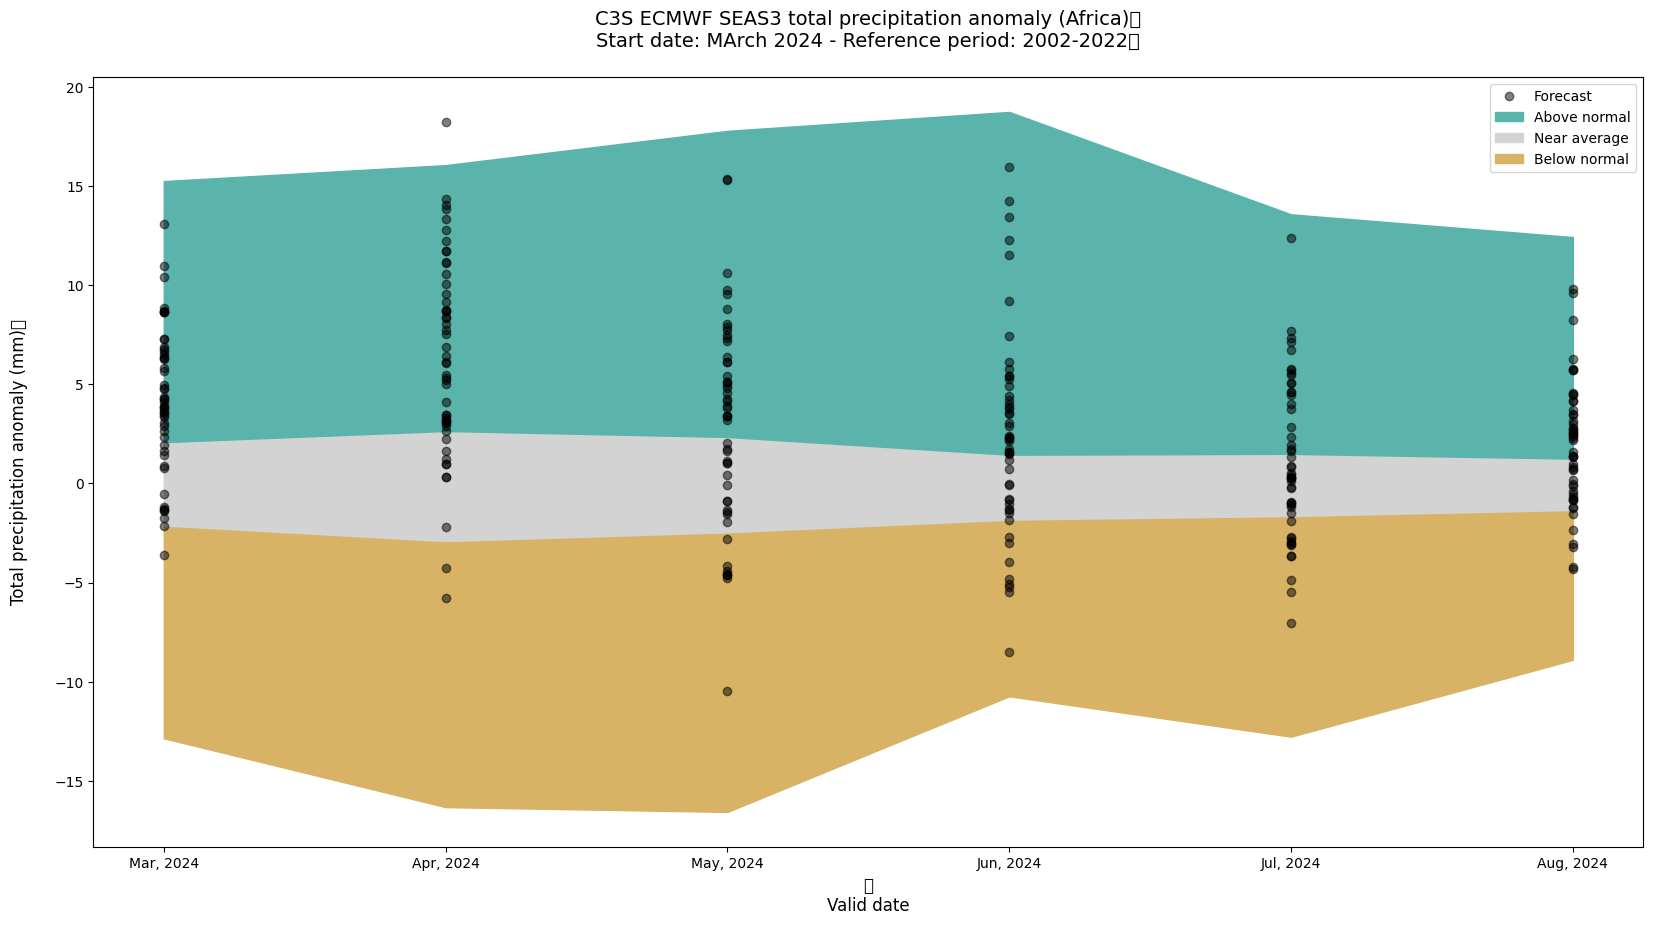

In [39]:
# Initiate the figure
fig=plt.figure(figsize=(20, 10))
ax=fig.gca()

# Plot the seasonal forecast anomalies + climatology boundaries as filled areas
ax.plot(anoms_Africa_m_yr.valid_time, anoms_Africa_m_yr.anomaly, marker='o', linestyle='', color='black', alpha=0.5, label='Forecast')
ax.fill_between(anoms_Africa_m_yr.index,P66,P100,color='#5ab4ac',label='Above normal')
ax.fill_between(anoms_Africa_m_yr.index,P33,P66,color='lightgray',label='Near average')
ax.fill_between(anoms_Africa_m_yr.index,P0,P33,color='#d8b365',label='Below normal')

# Customize plot settings
plt.title('C3S ECMWF SEAS3 total precipitation anomaly (Africa)' 
          + os.linesep + 
          'Start date: MArch 2024 - Reference period: 2002-2022' 
          + os.linesep, fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax.set_ylabel('Total precipitation anomaly (mm)' + os.linesep, fontsize=12)
ax.set_xlabel(os.linesep + 'Valid date', fontsize=12)

# Save the figure
fig.savefig('{}/TotalPrecForecastHindcastAnomaliesAfrica.png'.format(DATADIR) )

In [40]:
print("Minimum: ", P0)
# print(P33)
# print(P66)
print("Maximum: ", P100)

Minimum:  <xarray.DataArray (forecastMonth: 6)> Size: 48B
array([-12.85096801, -16.32268655, -16.56494249, -10.73510706,
       -12.77233776,  -8.89746254])
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    surface        float64 8B 0.0
    numdays        (forecastMonth) int32 24B 31 30 31 30 31 31
Maximum:  <xarray.DataArray (forecastMonth: 6)> Size: 48B
array([15.23700094, 16.04136402, 17.76987999, 18.72480365, 13.56213585,
       12.41628615])
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    surface        float64 8B 0.0
    numdays        (forecastMonth) int32 24B 31 30 31 30 31 31


In [41]:
# # Initiate the figure
# fig=plt.figure(figsize=(20, 10))
# ax=fig.gca()

# # Plot the seasonal forecast anomalies + climatology boundaries as filled areas
# ax.plot(anoms_nbo_m_yr.valid_time, anoms_nbo_m_yr.anomaly, marker='o', linestyle='', color='black', alpha=0.5, label='Forecast')
# ax.fill_between(anoms_nbo_m_yr.index,P66,P100,color='#5ab4ac',label='Above normal')
# ax.fill_between(anoms_nbo_m_yr.index,P33,P66,color='lightgray',label='Near average')
# ax.fill_between(anoms_nbo_m_yr.index,P0,P33,color='#d8b365',label='Below normal')

# # Customize plot settings
# plt.title('C3S ECMWF SEAS3 total precipitation anomaly (Nairobi)' 
#           + os.linesep + 
#           'Start date: MArch 2024 - Reference period: 2002-2022' 
#           + os.linesep, fontsize=14)

# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# ax.set_ylabel('Total precipitation anomaly (mm)' + os.linesep, fontsize=12)
# ax.set_xlabel(os.linesep + 'Valid date', fontsize=12)

# # Save the figure
# fig.savefig('{}/TotalPrecForecastHindcastAnomaliesNairobi.png'.format(DATADIR) )

In [42]:
# anoms_nbo_m_yr

## Calculate seasonal forecast 3-month anomalies

In [43]:
# Compute 3-month rolling averages
seas5_forecast_3m = seas5_forecast.rolling(forecastMonth=3).mean()
ds_hindcast_3m = ds_hindcast.rolling(forecastMonth=3).mean()

In [44]:
# Calculate anomalies
ds_hindcast_3m_hindcast_mean = ds_hindcast_3m.mean(['number','time'])
seas5_anomalies_3m_202403 = seas5_forecast_3m.tprate - ds_hindcast_3m_hindcast_mean.tprate

In [45]:
# Ensemble mean anomaly
seas5_anomalies_3m_202403_em = seas5_anomalies_3m_202403.mean('number')
seas5_anomalies_3m_202403_em

<xarray.DataArray 'tprate' (forecastMonth: 6, latitude: 180, longitude: 360)> Size: 2MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
          1.65240446e-10,  1.63601771e-10,  1.62291722e-10],
        [ 1.75779377e-10,  1.76547721e-10,  1.76466342e-10, ...,
          1.76289400e-10,  1.77170195e-10,  1.76785447e-10],
        [ 1.96392624e-10,  1.95987754e-10,  1.95624433e-10, ...,
          1.96926794e-10,  1.97134392e-10,  1.96515748e-10]],

       [[-1.00864150e-10, -1.00063402e-10, -9.98611055e-11, ...,
         -9.96662960e-11, -1.00119003e-10, -1.01376130e-10],
        [-2.16476420e-10, -2.11743983e-10, -2.08856793e-10, ...,
         -2.16477142e-10, -2.16340543e-10, -2.17781557e-10],
        [-2.57137728e-10, -2.60142574e-10, -2.64117839e-10, ...,
         -2.55446497e-10, -2.56469762e-10, -2.55436700e-10],
        ...,
        [ 2.79489504e-11,  2.65089409e-11,  2.62058760e-11, ...,
          3.14857064e-11,  3.01242399e-11,  2.90072358e-11],
        [ 8.51274953e-11,  8.52931267e-11,  8.53441415e-11, ...,
          8.55372231e-11,  8.47918680e-11,  8.45355938e-11],
        [ 1.36369957e-10,  1.36047784e-10,  1.35848138e-10, ...,
          1.36463993e-10,  1.37600653e-10,  1.36647083e-10]]],
      dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B ...
    surface        float64 8B 0.0
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5

In [46]:
# nbo_seas5_anomalies_3m_202403_em = ds_latlon_subset(seas5_anomalies_3m_202403_em, sub)

In [47]:
# Convert precipitation rate to accumulation in mm
# Calculate number of days for each forecast month and add it as coordinate information to the data array
vt = [ pd.to_datetime(seas5_anomalies_3m_202403_em.time.values) + relativedelta(months=fcmonth-1) for fcmonth in seas5_anomalies_3m_202403_em.forecastMonth]
seas5_anomalies_3m_202403_em = seas5_anomalies_3m_202403_em.assign_coords(valid_time=('forecastMonth',vt))
# seas5_anomalies_3m_202403_em ['month_year'] = seas5_anomalies_3m_202403_em['valid_time'].dt.strftime('%b, %Y')
vts = [[thisvt+relativedelta(months=-mm) for mm in range(3)] for thisvt in vt]
numdays = [np.sum([monthrange(dd.year,dd.month)[1] for dd in d3]) for d3 in vts]
seas5_anomalies_3m_202403_em = seas5_anomalies_3m_202403_em.assign_coords(numdays=('forecastMonth',numdays))


# Define names for the 3-month rolling archives, that give an indication over which months the average was built
vts_names = ['{} {} {} {}'.format(d3[2].strftime('%b'),d3[1].strftime('%b'),d3[0].strftime('%b'), d3[0].strftime('%Y'))  for d3 in vts]
seas5_anomalies_3m_202403_em = seas5_anomalies_3m_202403_em.assign_coords(valid_time=('forecastMonth',vts_names))
seas5_anomalies_3m_202403_em

# Convert the precipitation accumulations based on the number of days
seas5_anomalies_3m_202403_em_tp = seas5_anomalies_3m_202403_em * seas5_anomalies_3m_202403_em.numdays * 24 * 60 * 60 * 1000

# Add updated attributes
seas5_anomalies_3m_202403_em.attrs['units'] = 'mm'
seas5_anomalies_3m_202403_em_tp.attrs['long_name'] = 'SEAS3 3-monthly total precipitation ensemble mean anomaly for 6 lead-time months, start date in May 2021.'

In [48]:
seas5_anomalies_3m_202403_em_tp

<xarray.DataArray (forecastMonth: 6, latitude: 180, longitude: 360)> Size: 3MB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [ 1.27677224e+00,  1.26528890e+00,  1.25236279e+00, ...,
          1.31346326e+00,  1.30043776e+00,  1.29002444e+00],
        [ 1.39723511e+00,  1.40334252e+00,  1.40269566e+00, ...,
          1.40128918e+00,  1.40829045e+00,  1.40523216e+00],
        [ 1.56108569e+00,  1.55786746e+00,  1.55497950e+00, ...,
          1.56533170e+00,  1.56698186e+00,  1.56206438e+00]],

       [[-8.01748958e-01, -7.95383970e-01, -7.93775955e-01, ...,
         -7.92227454e-01, -7.95825934e-01, -8.05818580e-01],
        [-1.72072777e+00, -1.68311058e+00, -1.66016088e+00, ...,
         -1.72073350e+00, -1.71964771e+00, -1.73110204e+00],
        [-2.04393637e+00, -2.06782129e+00, -2.09941988e+00, ...,
         -2.03049312e+00, -2.03862684e+00, -2.03041524e+00],
        ...,
        [ 2.22160617e-01,  2.10714269e-01,  2.08305267e-01, ...,
          2.50273583e-01,  2.39451558e-01,  2.30572716e-01],
        [ 6.76661435e-01,  6.77978006e-01,  6.78383512e-01, ...,
          6.79918279e-01,  6.73993600e-01,  6.71956528e-01],
        [ 1.08397751e+00,  1.08141663e+00,  1.07982968e+00, ...,
          1.08472499e+00,  1.09376007e+00,  1.08618033e+00]]])
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
  * latitude       (latitude) float64 1kB 89.5 88.5 87.5 ... -87.5 -88.5 -89.5
  * longitude      (longitude) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    valid_time     (forecastMonth) <U16 384B 'Jan Feb Mar 2024' ... 'Jun Jul ...
    numdays        (forecastMonth) int32 24B 91 90 92 91 92 92
Attributes:
    long_name:  SEAS3 3-monthly total precipitation ensemble mean anomaly for...

In [49]:
# # Convert precipitation rate to accumulation in mm
# # Calculate number of days for each forecast month and add it as coordinate information to the data array
# vt = [ pd.to_datetime(nbo_seas5_anomalies_3m_202403_em.time.values) + relativedelta(months=fcmonth-1) for fcmonth in nbo_seas5_anomalies_3m_202403_em.forecastMonth]
# vts = [[thisvt+relativedelta(months=-mm) for mm in range(3)] for thisvt in vt]
# numdays = [np.sum([monthrange(dd.year,dd.month)[1] for dd in d3]) for d3 in vts]
# nbo_seas5_anomalies_3m_202403_em = nbo_seas5_anomalies_3m_202403_em.assign_coords(numdays=('forecastMonth',numdays))

# # Define names for the 3-month rolling archives, that give an indication over which months the average was built
# vts_names = ['{}{}{} {}'.format(d3[2].strftime('%b')[0],d3[1].strftime('%b')[0],d3[0].strftime('%b')[0], d3[0].strftime('%Y'))  for d3 in vts]
# nbo_seas5_anomalies_3m_202403_em = nbo_seas5_anomalies_3m_202403_em.assign_coords(valid_time=('forecastMonth',vts_names))
# seas5_anomalies_3m_202403_em

# # Convert the precipitation accumulations based on the number of days
# nbo_seas5_anomalies_3m_202403_em_tp = nbo_seas5_anomalies_3m_202403_em * nbo_seas5_anomalies_3m_202403_em.numdays * 24 * 60 * 60 * 1000

# # Add updated attributes
# nbo_seas5_anomalies_3m_202403_em.attrs['units'] = 'mm'
# nbo_seas5_anomalies_3m_202403_em_tp.attrs['long_name'] = 'SEAS3 3-monthly total precipitation ensemble mean anomaly for 6 lead-time months, start date in March 2024.'

In [50]:
# nbo_seas5_anomalies_3m_202403_em_tp

) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:528: UserWarning: Glyph 13 (
  super()._update_title_position(renderer)
) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:528: UserWarning: Glyph 13 (
  super()._update_title_position(renderer)
) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:525: UserWarning: Glyph 13 (
  return super().draw(renderer=renderer, **kwargs)


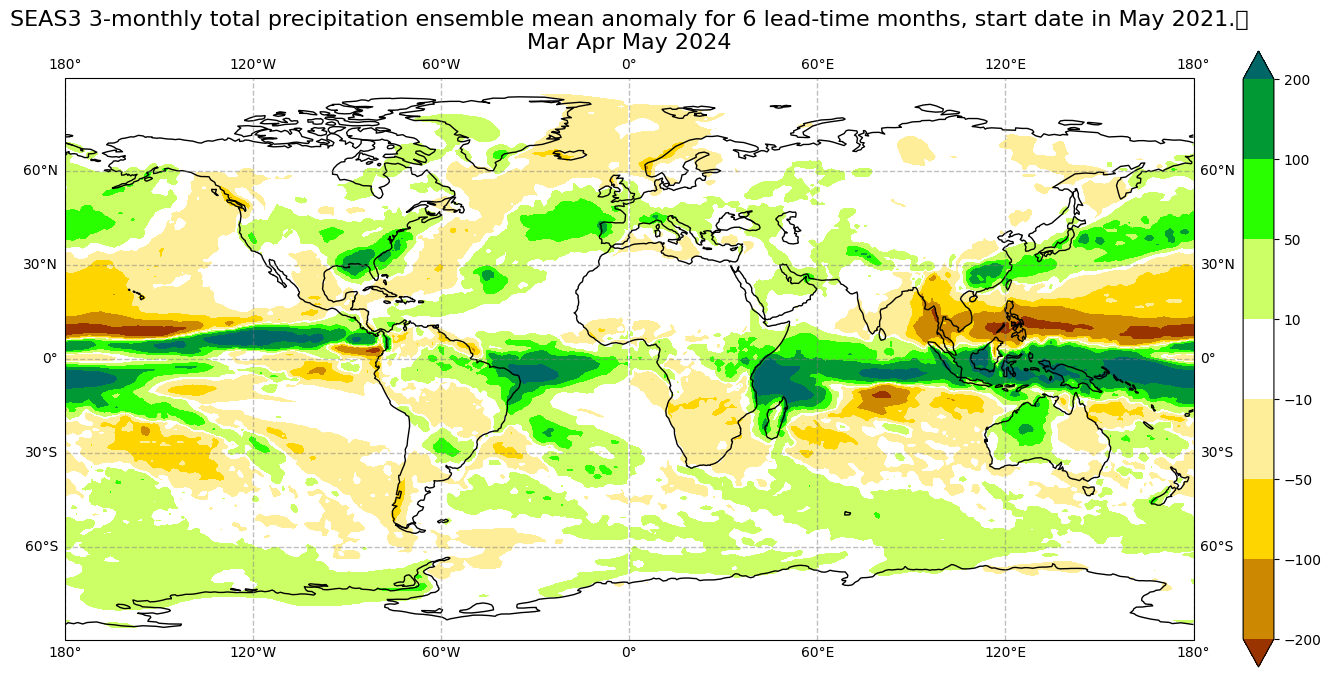

interactive(children=(Dropdown(description='Valid Time:', options=(('Mar Apr May 2024', 3), ('Apr May Jun 2024…

In [51]:
# Visualise 3-monthly total precipitation ensemble mean anomalies
vts_names
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)]

tp_colors = [(153/255.,51/255.,0),(204/255.,136/255.,0),(1,213/255.,0),
             (1,238/255.,153/255.),(1,1,1),(204/255.,1,102/255.),
             (42/255.,1,0),(0,153/255.,51/255.),(0,102/255.,102/255.)]  
tp_levels = [-200,-100,-50,-10,10,50,100,200]



def plot_leadt(ds, leadt_end):
    array = ds.sel(forecastMonth=leadt_end)
    print(array)
    fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    im = plt.contourf(array.longitude, array.latitude, array, 
                      levels=tp_levels, colors=tp_colors, extend='both')
    ax.set_title(f'{array.long_name}' + os.linesep + f'{array.valid_time.values}', fontsize=16)
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    ax.coastlines(color='black')
    cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
    cbar.set_label(array.units)
    
    return
    
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)] 
a=widgets.interact(plot_leadt, ds=widgets.fixed(seas5_anomalies_3m_202403_em_tp), 
                   leadt_end=widgets.Dropdown(options=dropdown_opts,description='Valid Time:', 
                                              style={'description_width': 'initial'}))

In [52]:
# vts_names
# dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)]

# tp_colors = [(153/255.,51/255.,0),(204/255.,136/255.,0),(1,213/255.,0),
#              (1,238/255.,153/25.),(1,1,1),(204/255.,1,102/255.),
#              (42/255.,1,0),(0,153/255.,51/255.),(0,102/255.,102/255.)]  
# tp_levels = [-200,-100,-50,-10,10,50,100,200]



# def plot_leadt(ds, leadt_end):
#     array = ds.sel(forecastMonth=leadt_end)
#     print(array)
#     fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
#     im = plt.contourf(array.longitude, array.latitude, array, 
#                       levels=tp_levels, colors=tp_colors, extend='both')
#     ax.set_title(f'{array.long_name}' + os.linesep + f'{array.valid_time.values}', fontsize=16)
#     ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
#     ax.coastlines(color='black')
#     cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
#     cbar.set_label(array.units)
    
#     return
    
# dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)] 
# a=widgets.interact(plot_leadt, ds=widgets.fixed(nbo_seas5_anomalies_3m_202403_em_tp), 
#                    leadt_end=widgets.Dropdown(options=dropdown_opts,description='Valid Time:', 
#                                               style={'description_width': 'initial'}))

In [53]:

# define Africa
sub = (40, -23, -35, 55) #North, West, South, East
seas5_Africa_anomalies_3m_202403_em_tp = ds_latlon_subset(seas5_anomalies_3m_202403_em_tp, sub)
seas5_Africa_anomalies_3m_202403_em_tp

<xarray.DataArray (forecastMonth: 6, latitude: 75, longitude: 78)> Size: 281kB
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [ 2.24463406e+00,  3.77505507e+00, -1.49973272e+00, ...,
         -1.81071617e+01, -2.33515099e+01, -2.41783168e+01],
        [ 5.80812948e+00,  1.05604060e+01,  1.26321764e+01, ...,
         -2.05032832e+01, -1.23085023e+01, -1.31157311e+01],
        [ 6.05844539e+00,  9.90113260e+00,  1.93918719e+01, ...,
         -1.92583612e+01, -8.13779735e+00, -1.82768859e+00]],

       [[-8.39508409e+00, -7.53247084e+00, -6.45366639e+00, ...,
          4.06915151e-01,  1.68963441e+00,  1.39082743e+00],
        [-6.14711399e+00, -6.01877420e+00, -3.73326632e+00, ...,
          6.01560196e-01,  3.99344587e+00,  5.57852658e+00],
        [-5.34773364e+00, -6.28568497e+00, -3.89115334e+00, ...,
          3.64771139e+00,  4.24401507e+00,  4.55155543e+00],
        ...,
        [-1.45394359e+01, -1.59753685e+01, -1.94375639e+01, ...,
         -4.49260262e+00, -9.99158736e+00, -9.95745690e+00],
        [-2.83106990e+00, -3.52756423e+00, -1.88882811e+00, ...,
         -7.06932383e+00, -2.72592669e+00, -2.24496433e+00],
        [ 6.11906877e+00,  4.43062638e+00,  9.26994812e+00, ...,
         -6.89288723e+00, -3.01271454e+00, -3.05597573e+00]]])
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
  * latitude       (latitude) float64 600B 39.5 38.5 37.5 ... -32.5 -33.5 -34.5
    valid_time     (forecastMonth) <U16 384B 'Jan Feb Mar 2024' ... 'Jun Jul ...
    numdays        (forecastMonth) int32 24B 91 90 92 91 92 92
  * longitude      (longitude) float64 624B -22.5 -21.5 -20.5 ... 52.5 53.5 54.5
Attributes:
    long_name:  SEAS3 3-monthly total precipitation ensemble mean anomaly for...

) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:528: UserWarning: Glyph 13 (
  super()._update_title_position(renderer)
) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:528: UserWarning: Glyph 13 (
  super()._update_title_position(renderer)
) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:525: UserWarning: Glyph 13 (
  return super().draw(renderer=renderer, **kwargs)


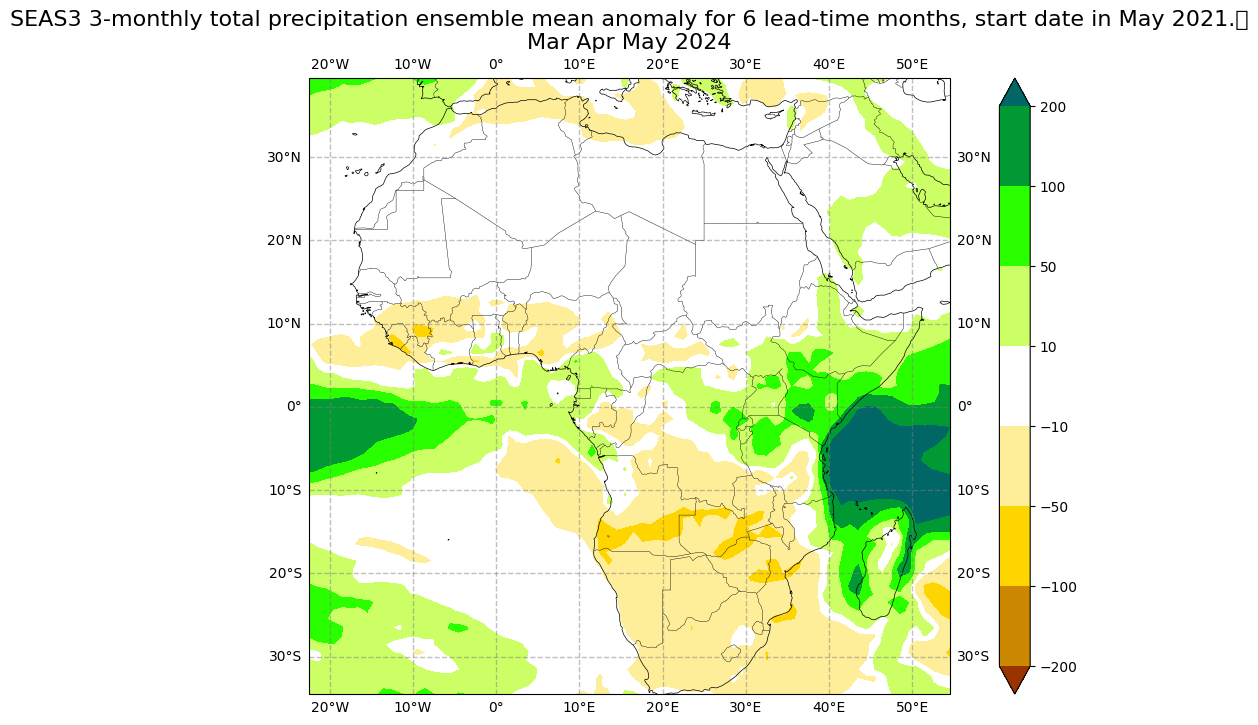

interactive(children=(Dropdown(description='Valid Time:', options=(('Mar Apr May 2024', 3), ('Apr May Jun 2024…

In [54]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cf

# Visualise 3-monthly total precipitation ensemble mean anomalies
vts_names
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)]

tp_colors = [(153/255.,51/255.,0),(204/255.,136/255.,0),(1,213/255.,0),
             (1,238/255.,153/255.),(1,1,1),(204/255.,1,102/255.),
             (42/255.,1,0),(0,153/255.,51/255.),(0,102/255.,102/255.)]  
tp_levels = [-200,-100,-50,-10,10,50,100,200]



def plot_leadt(ds, leadt_end):
    array = ds.sel(forecastMonth=leadt_end)
    print(array)
    fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    im = plt.contourf(array.longitude, array.latitude, array, 
                      levels=tp_levels, colors=tp_colors, extend='both')
    ax.set_title(f'{array.long_name}' + os.linesep + f'{array.valid_time.values}', fontsize=16)
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.3)
    cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
    cbar.set_label(array.units)
    
    return
    
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)] 
a=widgets.interact(plot_leadt, ds=widgets.fixed(seas5_Africa_anomalies_3m_202403_em_tp), 
                   leadt_end=widgets.Dropdown(options=dropdown_opts,description='Valid Time:', 
                                              style={'description_width': 'initial'}))

In [55]:
# define Kenya 
# define Africa
sub = (5.5, 33, -5.5, 43) #North, West, South, East
seas5_Kenya_anomalies_3m_202403_em_tp = ds_latlon_subset(seas5_anomalies_3m_202403_em_tp, sub)
seas5_Kenya_anomalies_3m_202403_em_tp

<xarray.DataArray (forecastMonth: 6, latitude: 12, longitude: 10)> Size: 6kB
array([[[            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
        [            nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan,             nan,             nan,
                     nan],
...
        [ 4.23067590e+01,  1.98319911e+01,  2.35923884e+01,
          1.98936192e+01,  1.39910364e+01,  6.11483103e+00,
          7.84827046e+00,  2.74373586e+01,  7.63975688e+01,
          1.00609246e+02],
        [ 2.07303419e+01,  7.74178520e+00,  5.24336460e+00,
          4.05751450e+00,  7.65333988e+00,  7.23231784e+00,
          1.66902981e+01,  8.78391257e+01,  1.14341757e+02,
          9.96574087e+01],
        [ 3.67123361e+00,  1.34062323e+00,  2.50235123e+00,
          4.30097476e+00,  9.79841647e+00,  1.10253665e+01,
          4.66962563e+01,  1.22482440e+02,  1.08528190e+02,
          1.01213669e+02],
        [ 7.24717815e-01,  8.20193526e-01,  2.75502693e+00,
          3.55884733e+00,  5.34710751e+00,  1.73173172e+01,
          9.34143844e+01,  1.03940618e+02,  1.02012552e+02,
          9.55691737e+01],
        [ 3.77278408e-01,  3.16219222e-01,  1.07417212e+00,
          3.05744508e+00,  7.17450212e+00,  2.15374780e+01,
          7.69917697e+01,  9.14369129e+01,  8.87536437e+01,
          8.34094855e+01]]])
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
  * latitude       (latitude) float64 96B 5.5 4.5 3.5 2.5 ... -3.5 -4.5 -5.5
  * longitude      (longitude) float64 80B 33.5 34.5 35.5 ... 40.5 41.5 42.5
    valid_time     (forecastMonth) <U16 384B 'Jan Feb Mar 2024' ... 'Jun Jul ...
    numdays        (forecastMonth) int32 24B 91 90 92 91 92 92
Attributes:
    long_name:  SEAS3 3-monthly total precipitation ensemble mean anomaly for...

In [56]:
# import requests

# url = "https://api.geoapify.com/v1/boundaries/part-of?id=51777aa52c43e4424059d8d85c666666e6bff00103f9018794ae02000000009203084b69616d62657265&geometry=geometry_1000&apiKey=8dac591875e148b6afca8f3615cd4cf1"
          
# response = requests.get(url)
# print(response.json())

In [57]:
# data_geo = response.json()


In [58]:
# data_geo['features'][0]['geometry']

In [59]:
# kiambere_geo = data_geo['features'][0]['geometry']

In [60]:
# cf.ShapelyFeature(kiambere_geo, crs=4326)

) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:528: UserWarning: Glyph 13 (
  super()._update_title_position(renderer)
) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:528: UserWarning: Glyph 13 (
  super()._update_title_position(renderer)
) missing from current font.s\llms\lib\site-packages\cartopy\mpl\geoaxes.py:525: UserWarning: Glyph 13 (
  return super().draw(renderer=renderer, **kwargs)


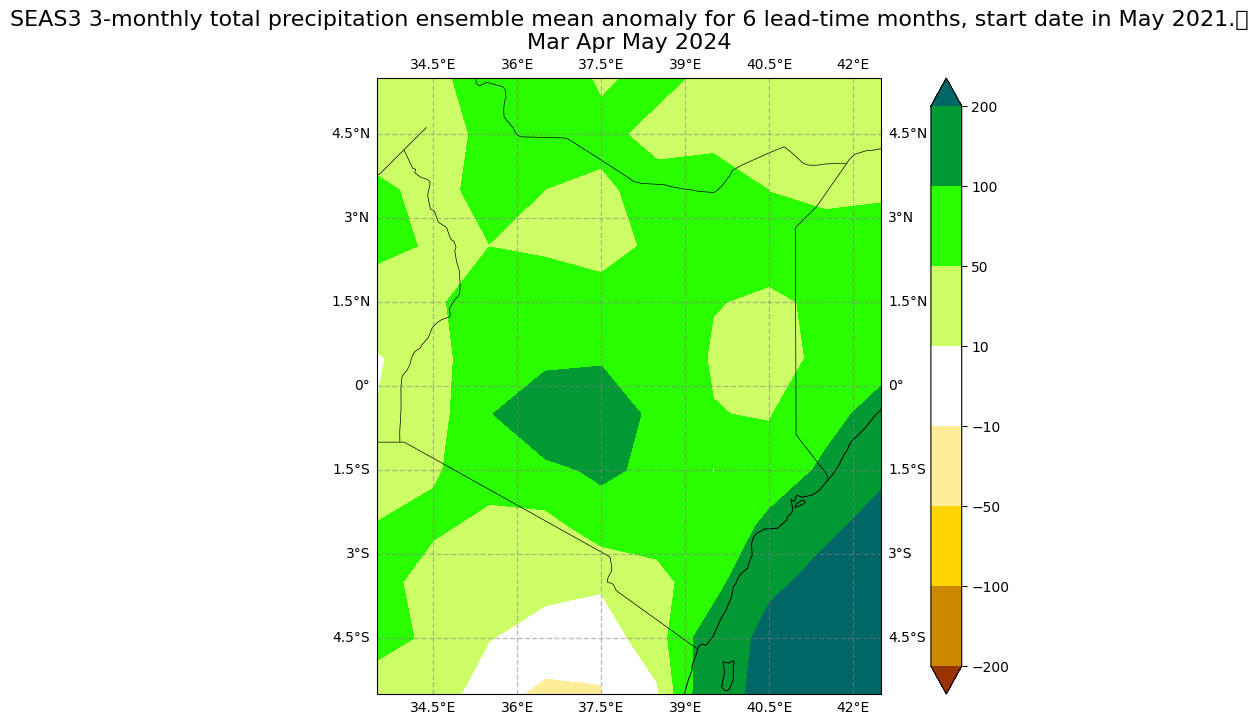

interactive(children=(Dropdown(description='Valid Time:', options=(('Mar Apr May 2024', 3), ('Apr May Jun 2024…

In [61]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cf

# Visualise 3-monthly total precipitation ensemble mean anomalies
vts_names
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)]

tp_colors = [(153/255.,51/255.,0),(204/255.,136/255.,0),(1,213/255.,0),
             (1,238/255.,153/255.),(1,1,1),(204/255.,1,102/255.),
             (42/255.,1,0),(0,153/255.,51/255.),(0,102/255.,102/255.)]  
tp_levels = [-200,-100,-50,-10,10,50,100,200]



def plot_leadt(ds, leadt_end):
    array = ds.sel(forecastMonth=leadt_end)
    print(array)
    fig, ax = plt.subplots(1, 1, figsize = (16, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    im = plt.contourf(array.longitude, array.latitude, array, 
                      levels=tp_levels, colors=tp_colors, extend='both')
    ax.set_title(f'{array.long_name}' + os.linesep + f'{array.valid_time.values}', fontsize=16)
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    ax.add_feature(cf.COASTLINE.with_scale("50m"), lw=0.7)
    ax.add_feature(cf.BORDERS.with_scale("50m"), lw=0.5)
    ax.add_feature(cf.STATES.with_scale("50m"), lw=0.3)
    # ax.add_feature(cf.ShapelyFeature(kiambere_geo, crs=4326), lw=0.3)
    cbar = plt.colorbar(im,fraction=0.05, pad=0.04)
    cbar.set_label(array.units)
    
    return
    
dropdown_opts = [(vts_names[mm-1],mm) for mm in range(3,7)] 
a=widgets.interact(plot_leadt, ds=widgets.fixed(seas5_Kenya_anomalies_3m_202403_em_tp), 
                   leadt_end=widgets.Dropdown(options=dropdown_opts,description='Valid Time:', 
                                              style={'description_width': 'initial'}))

In [62]:
kiambere_anomalies_3m_202403_em_tp = seas5_Kenya_anomalies_3m_202403_em_tp.sel(latitude=-0.7, longitude=37.783, method="nearest")
kiambere_anomalies_3m_202403_em_tp

<xarray.DataArray (forecastMonth: 6)> Size: 48B
array([         nan,          nan, 141.41086515, 168.91929601,
        65.06104281,  42.71004117])
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
    latitude       float64 8B -0.5
    longitude      float64 8B 37.5
    valid_time     (forecastMonth) <U16 384B 'Jan Feb Mar 2024' ... 'Jun Jul ...
    numdays        (forecastMonth) int32 24B 91 90 92 91 92 92
Attributes:
    long_name:  SEAS3 3-monthly total precipitation ensemble mean anomaly for...

In [63]:
df = kiambere_anomalies_3m_202403_em_tp.to_dataframe("anomaly_mm")
df

,time,surface,latitude,longitude,valid_time,numdays,anomaly_mm
forecastMonth,,,,,,,
1,2024-03-01,0.0,-0.5,37.5,Jan Feb Mar 2024,91,NaN
2,2024-03-01,0.0,-0.5,37.5,Feb Mar Apr 2024,90,NaN
3,2024-03-01,0.0,-0.5,37.5,Mar Apr May 2024,92,141.410865
4,2024-03-01,0.0,-0.5,37.5,Apr May Jun 2024,91,168.919296
5,2024-03-01,0.0,-0.5,37.5,May Jun Jul 2024,92,65.061043
6,2024-03-01,0.0,-0.5,37.5,Jun Jul Aug 2024,92,42.710041


In [64]:
# lon: 39.73580278030964
# lat: -0.32341025
garrisa_anomalies_3m_202403_em_tp = seas5_Kenya_anomalies_3m_202403_em_tp.sel(latitude=-0.3234, longitude=39.7358, method="nearest")
garrisa_anomalies_3m_202403_em_tp

<xarray.DataArray (forecastMonth: 6)> Size: 48B
array([        nan,         nan, 50.8285878 , 40.53667044,  3.27039884,
        3.38614676])
Coordinates:
  * forecastMonth  (forecastMonth) int32 24B 1 2 3 4 5 6
    time           datetime64[ns] 8B 2024-03-01
    surface        float64 8B 0.0
    latitude       float64 8B -0.5
    longitude      float64 8B 39.5
    valid_time     (forecastMonth) <U16 384B 'Jan Feb Mar 2024' ... 'Jun Jul ...
    numdays        (forecastMonth) int32 24B 91 90 92 91 92 92
Attributes:
    long_name:  SEAS3 3-monthly total precipitation ensemble mean anomaly for...

In [65]:
df = garrisa_anomalies_3m_202403_em_tp.to_dataframe("anomaly_mm")
df

,time,surface,latitude,longitude,valid_time,numdays,anomaly_mm
forecastMonth,,,,,,,
1,2024-03-01,0.0,-0.5,39.5,Jan Feb Mar 2024,91,NaN
2,2024-03-01,0.0,-0.5,39.5,Feb Mar Apr 2024,90,NaN
3,2024-03-01,0.0,-0.5,39.5,Mar Apr May 2024,92,50.828588
4,2024-03-01,0.0,-0.5,39.5,Apr May Jun 2024,91,40.536670
5,2024-03-01,0.0,-0.5,39.5,May Jun Jul 2024,92,3.270399
6,2024-03-01,0.0,-0.5,39.5,Jun Jul Aug 2024,92,3.386147


In [66]:
# garrisa_anomalies_3m_202403_em_tp.values

In [67]:
from datetime import date

today = date.today()
today

datetime.date(2024, 5, 20)

In [68]:
import calendar
print("Current Month: ", calendar.month_abbr[today.month-2], calendar.month_abbr[today.month-1], calendar.month_abbr[today.month])

Current Month:  Mar Apr May


In [69]:
seasons_ke = ['Mar Apr May', 'Jun Jul Aug', 'Sep Oct Nov', 'Dec Jan Feb']

In [70]:
def extract_season_str(value):
    return value[0:11]

df['seasons'] = df.valid_time.apply(extract_season_str)
df

,time,surface,latitude,longitude,valid_time,numdays,anomaly_mm,seasons
forecastMonth,,,,,,,,
1,2024-03-01,0.0,-0.5,39.5,Jan Feb Mar 2024,91,NaN,Jan Feb Mar
2,2024-03-01,0.0,-0.5,39.5,Feb Mar Apr 2024,90,NaN,Feb Mar Apr
3,2024-03-01,0.0,-0.5,39.5,Mar Apr May 2024,92,50.828588,Mar Apr May
4,2024-03-01,0.0,-0.5,39.5,Apr May Jun 2024,91,40.536670,Apr May Jun
5,2024-03-01,0.0,-0.5,39.5,May Jun Jul 2024,92,3.270399,May Jun Jul
6,2024-03-01,0.0,-0.5,39.5,Jun Jul Aug 2024,92,3.386147,Jun Jul Aug


In [71]:
new_df = df[df.seasons.isin(seasons_ke)]
new_df

,time,surface,latitude,longitude,valid_time,numdays,anomaly_mm,seasons
forecastMonth,,,,,,,,
3,2024-03-01,0.0,-0.5,39.5,Mar Apr May 2024,92,50.828588,Mar Apr May
6,2024-03-01,0.0,-0.5,39.5,Jun Jul Aug 2024,92,3.386147,Jun Jul Aug


In [74]:
def filter_seasons_location(df, location_seasons):
    df.seasons = df.valid_time.apply(extract_season_str)
    filtered_df = df[df.seasons.isin(location_seasons)]
    return filtered_df

In [76]:
filtered_df = filter_seasons_location(df, seasons_ke)

In [77]:
def get_current_season_anomaly(df):
    current_month = calendar.month_abbr[today.month]
    for season in df.seasons:
        if current_month in season:
            anomaly = df.loc[df.seasons==season, 'anomaly_mm'].iloc[0]
    return anomaly

get_current_season_anomaly(filtered_df)

50.828587802698166